# Week 5 - Classifying Meanings & Documents (With Machine Learning)

Recall that Week 1 of this course focused on how to find and extract text data, while weeks 2 through 4 each covered a different type of content representations:

2. computational linguistics (e.g., keyword count)
3. clustering and topic modeling (e.g., LDA)
4. embeddings (e.g., _word2vec_)

Now we show how classification, arguably the most common social science task, can be done with different representations. Note that the second representation, *clustering*, allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. Classification, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

We will show how to use a variety of classification methods, including Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data.

In [ ]:
# run if on Colab
from google.colab import drive
drive.mount('/content/drive')

In [10]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
!pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /private/var/folders/1w/6x7_f0pn7417tk3p1dnytgvm0000gn/T/pip-req-build-8kyf3ipw
  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /private/var/folders/1w/6x7_f0pn7417tk3p1dnytgvm0000gn/T/pip-req-build-8kyf3ipw
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit b17a265d3b8253424e5b38872457f7437909a65d
  Preparing metadata (setup.py) ... done


# Annotations

This is a course on "computational" content analysis, but the best computer today is arguably still the human brain (We'll see how far Large Language Models can go). Our aim is to augment human intelligence and scholarship. One of the most important strategies is to have real, live _Homo sapiens_ annotate text, assigning numbers or categories to individual texts. We can computationally compare annotations across humans, and we can use annotations to train computational models.

Let's take a quick look at Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" style="width:500px">

In [3]:
# Remember if you are on Google Colab, you need to upload or `git clone` the datafile
# and your path will probably be something like "#drive/MyDrive/{where you store on Google Drive}/data/pyAnno/testdata_numerical.txt"
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [4]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [5]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [6]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [7]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


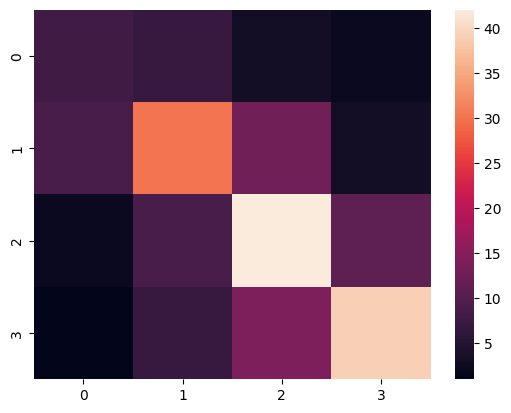

In [8]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [9]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [10]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [11]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [12]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [13]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


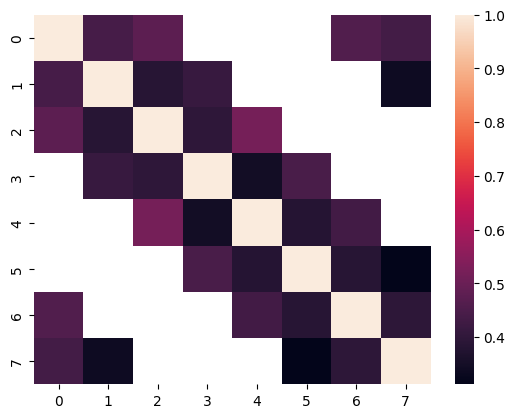

In [14]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others.

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [15]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)

pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [16]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [17]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

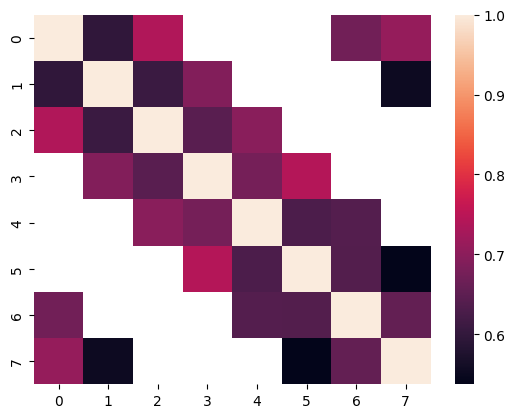

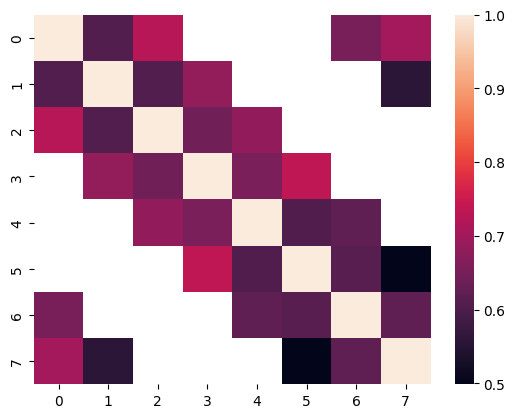

In [18]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [19]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <font color="red">*Exercise 1*</font>

<font color="red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the [MTurk slides on Canvas](https://canvas.uchicago.edu/courses/54694/files/folder/unfiled?preview=10675152), or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [23]:
import pandas as pd

In [66]:
mTurk = pd.read_csv("Batch_5183983_batch_results.csv")
mTurk.head()

,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,...,RejectionTime,RequesterFeedback,WorkTimeInSeconds,LifetimeApprovalRate,Last30DaysApprovalRate,Last7DaysApprovalRate,Input.text,Answer.sentiment.label,Approve,Reject
0,3TTPFEFXCSJP2SXEFESFRGTOKE16H4,3D9187VUCLJUQP7IA6EKRE1A1GOIUT,Sentiment analysis,Classify posts as exhibiting depression or not,"sentiment, text, purpose, depression, meaning",$0.25,Tue Feb 06 09:07:47 PST 2024,5,BatchId:5183983;OriginalHitTemplateId:928390909;,600,...,NaN,NaN,124,100% (1/1),100% (1/1),100% (1/1),Eating your friend's food Hi I'm curious about...,Non-depressed,NaN,NaN
1,3TTPFEFXCSJP2SXEFESFRGTOKE16H4,3D9187VUCLJUQP7IA6EKRE1A1GOIUT,Sentiment analysis,Classify posts as exhibiting depression or not,"sentiment, text, purpose, depression, meaning",$0.25,Tue Feb 06 09:07:47 PST 2024,5,BatchId:5183983;OriginalHitTemplateId:928390909;,600,...,NaN,NaN,143,100% (2/2),100% (2/2),100% (2/2),Eating your friend's food Hi I'm curious about...,Non-depressed,NaN,NaN
2,3TTPFEFXCSJP2SXEFESFRGTOKE16H4,3D9187VUCLJUQP7IA6EKRE1A1GOIUT,Sentiment analysis,Classify posts as exhibiting depression or not,"sentiment, text, purpose, depression, meaning",$0.25,Tue Feb 06 09:07:47 PST 2024,5,BatchId:5183983;OriginalHitTemplateId:928390909;,600,...,NaN,NaN,73,100% (1/1),100% (1/1),100% (1/1),Eating your friend's food Hi I'm curious about...,Non-depressed,NaN,NaN
3,3TTPFEFXCSJP2SXEFESFRGTOKE16H4,3D9187VUCLJUQP7IA6EKRE1A1GOIUT,Sentiment analysis,Classify posts as exhibiting depression or not,"sentiment, text, purpose, depression, meaning",$0.25,Tue Feb 06 09:07:47 PST 2024,5,BatchId:5183983;OriginalHitTemplateId:928390909;,600,...,NaN,NaN,277,100% (1/1),100% (1/1),100% (1/1),Eating your friend's food Hi I'm curious about...,Depressed,NaN,NaN
4,3TTPFEFXCSJP2SXEFESFRGTOKE16H4,3D9187VUCLJUQP7IA6EKRE1A1GOIUT,Sentiment analysis,Classify posts as exhibiting depression or not,"sentiment, text, purpose, depression, meaning",$0.25,Tue Feb 06 09:07:47 PST 2024,5,BatchId:5183983;OriginalHitTemplateId:928390909;,600,...,NaN,NaN,351,100% (1/1),100% (1/1),100% (1/1),Eating your friend's food Hi I'm curious about...,Depressed,NaN,NaN


In [67]:
mTurk = mTurk[['Input.text','Answer.sentiment.label']]
mTurk[::5]


,Input.text,Answer.sentiment.label
0,Eating your friend's food Hi I'm curious about...,Non-depressed
5,I wish I could have done things differently I ...,Depressed
10,I just drove 1000 miles cause my Gma tried to ...,Depressed
15,Only 7 cigarettes today This sounds really stu...,Non-depressed
20,"Need New Friends? Hey everyone, I'm a sixteen ...",Depressed
25,How do you make friends in your thirties I am ...,Depressed
30,How to not be discouraged that I suck and peop...,Depressed
35,I made a word cloud of all my depressive posts...,Depressed
40,I [37F] found out I have a half-brother from m...,Depressed
45,Does anyone else have friends that act like th...,Depressed


In [68]:
mTurk['index'] = mTurk.index
mTurk['number'] = (mTurk['index'].astype(int) // 5).apply(math.floor)
mTurk['person'] = mTurk['index'] % 5
mTurk['label'] = mTurk['Answer.sentiment.label'].replace('Non-depressed', 0).replace('Depressed', 1)
mTurk.drop(['index', 'Input.text', 'Answer.sentiment.label'], axis=1, inplace=True)
mTurk[::8]

,number,person,label
0,0,0,0
8,1,3,1
16,3,1,1
24,4,4,0
32,6,2,1
40,8,0,1
48,9,3,0


In [69]:
mTurk = mTurk.pivot(index='number', columns='person', values='label')
mTurk[:10]

person,0,1,2,3,4
number,,,,,
0,0,0,0,1,1
1,1,1,1,1,1
2,1,1,1,0,1
3,0,1,1,1,1
4,1,0,0,0,0
5,1,1,1,1,0
6,1,0,1,1,1
7,1,1,0,1,1
8,1,1,1,1,1


In [71]:
anno = AnnotationsContainer.from_array(mTurk.values)

In [72]:
anno.annotations

array([[0, 0, 0, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1],
       [0, 1, 1, 1, 1],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 1, 0],
       [1, 0, 1, 1, 1],
       [1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1],
       [0, 1, 1, 1, 1]])

In [73]:
anno.labels

[0, 1]

In [74]:
pyanno.measures.agreement.labels_frequency(anno.annotations,2)

array([0.25454545, 0.74545455])

[[1. 2. 0. 0.]
 [2. 6. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


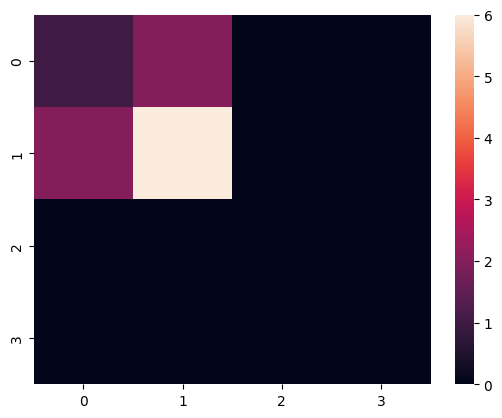

In [75]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

In [76]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.08333333333333333

In [77]:
fleiss_kappa(anno.annotations[::])

0.08972125435540049

In [78]:
krippendorffs_alpha(anno.annotations[::])

0.10627177700348434

In [79]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.08333333333333333

In [80]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[ 1.          0.08333333  0.08333333 -0.375      -0.27906977]
 [ 0.08333333  1.          0.54166667  0.08333333  0.23255814]
 [ 0.08333333  0.54166667  1.          0.08333333  0.23255814]
 [-0.375       0.08333333  0.08333333  1.          0.23255814]
 [-0.27906977  0.23255814  0.23255814  0.23255814  1.        ]]


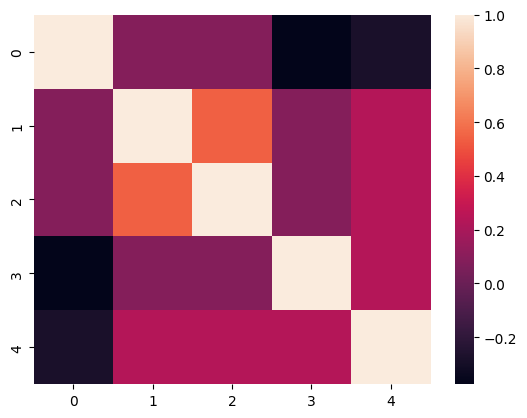

In [81]:
ax = seaborn.heatmap(m)
plt.show()

In [82]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)

pairwise_metric_average(cohens_kappa, anno.annotations)

0.0918604651162791

In [83]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.08333333333333326

In [84]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.09186046511627911

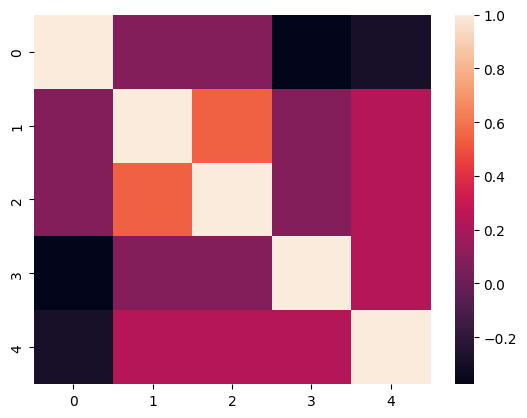

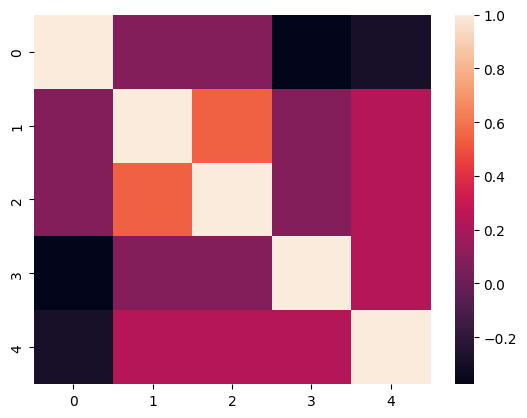

In [85]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

In [86]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.09330127018922192 0.09330127018922192


Discussion:
- Almost all of the correlations between "coders" are very low. Some are even negative.
- One reason for this is that these are not in fact 10 individual coders, but 50. Amazon separates each text into a different task, and I couldn't find a way to make each coder do all 10 tasks.
- This also reflects the difficulty of the subject matter. Some posts may express negative emotion but not be depressed, leading to false positives, or be not-obviously depressed, causing false negatives.
- I would expect that, like machine learning models, human assessors would do better if they were given some examples of depressed and non-depressed posts before beginning the lassification task.

# Simple Simulated Examples for Classification

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`).

The four data patterns include:
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

We use the popular `train_test_split()` function from `sklearn`, and the data pattern function source code is copied below for your convenience from `lucem_illud`'s [cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py) file.

In [159]:
def randomSplit(numPerCategory = 500):
    datDict = {
        'vect' : [np.random.rand(2) * 2 - 1 for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def andSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        y = np.random.random_sample() * 2 - 1
        if noise >= 0:
            x = np.random.random_sample() - cat - (np.random.random_sample() - cat) * noise
        else:
            x = (1 - noise * np.random.random_sample()) - cat
        return np.array([x, y])
    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def xorSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        if cat == 1:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        else:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        return np.array([x, y])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def targetSplit(noise = 0, numPerCategory = 500, innerRad = .3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def multiBlobs(noise = 0, numPerCategory = 500, centers = 5):
    if isinstance(centers, int):
        n_samples = numPerCategory * centers
    else:
        n_samples = numPerCategory * len(centers)
    X, y = sklearn.datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std = (.8 * (noise * 2 + 1)))
    datDict = {
        'vect' : list(X),
        'category' : y,
    }
    return pandas.DataFrame(datDict)

In [163]:
noise = .2

dfTrain0, dfTest0 = sklearn.model_selection.train_test_split(targetSplit(noise), test_size=.2)
dfTrain1, dfTest1 = sklearn.model_selection.train_test_split(andSplit(noise), test_size=.2)
dfTrain2, dfTest2 = sklearn.model_selection.train_test_split(xorSplit(noise), test_size=.2)
dfTrain3, dfTest3 = sklearn.model_selection.train_test_split(multiBlobs(noise), test_size=.2)

noise = .4
dfTrain4, dfTest4 = sklearn.model_selection.train_test_split(targetSplit(noise), test_size=.2)
dfTrain5, dfTest5 = sklearn.model_selection.train_test_split(andSplit(noise), test_size=.2)
dfTrain6, dfTest6 = sklearn.model_selection.train_test_split(xorSplit(noise), test_size=.2)
dfTrain7, dfTest7 = sklearn.model_selection.train_test_split(multiBlobs(noise), test_size=.2)


noise = .1
dfTrain8, dfTest8 = sklearn.model_selection.train_test_split(targetSplit(noise), test_size=.2)
dfTrain9, dfTest9 = sklearn.model_selection.train_test_split(andSplit(noise), test_size=.2)
dfTrain10, dfTest10 = sklearn.model_selection.train_test_split(xorSplit(noise), test_size=.2)
dfTrain11, dfTest11 = sklearn.model_selection.train_test_split(multiBlobs(noise), test_size=.2)

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [89]:
dfTrain

,vect,category
385,"[0.18386249148047643, 0.3948707639691611]",1
734,"[0.18771573069557876, -0.04472630786427083]",0
114,"[-0.22082450959354602, 0.139811815815535]",0
350,"[-0.21613169382986727, -0.22093475990539943]",0
323,"[0.20011371526393285, -0.6931637660528118]",1
...,...,...
538,"[-0.002915663481629118, -0.34120449099302186]",0
286,"[-0.039062639442322605, -0.27325518107302155]",0
743,"[0.5423114299080913, 0.2765825742724145]",1
748,"[-0.10926830586465126, 0.028232350522993624]",0


So, dfTrain has two columns, vect and category. We can plot this with `plotter()` from [lucem_illud/lucem_illud/cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py). Here's the source code:

In [90]:
def plotter(df):
    fig, ax = plt.subplots(figsize = (10,10))
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


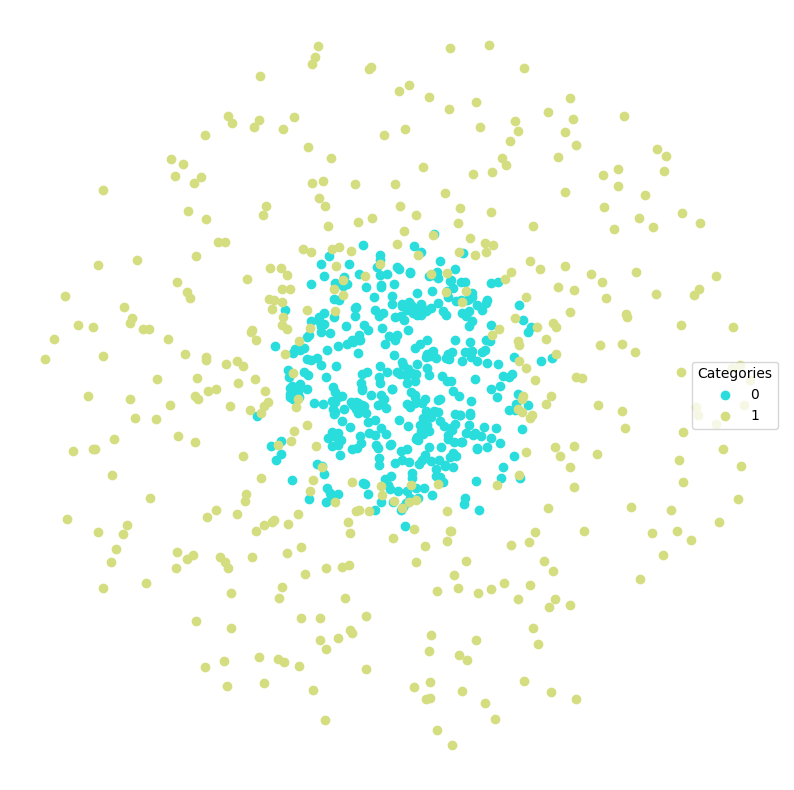

In [91]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [185]:
#Bayes
clf0 = sklearn.naive_bayes.GaussianNB()

#Analogizes
clf1 = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
clf2 = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf3 = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
clf4 = sklearn.linear_model.LogisticRegression()

#Symbolists
clf5 = sklearn.tree.DecisionTreeClassifier()
clf6 = sklearn.ensemble.RandomForestClassifier()

#Connectionists
clf7 = sklearn.neural_network.MLPClassifier() #extremely slow

#Ensemble
clf8 = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [ ]:
dir(sklearn)

Now we fit the model by giving it our training data

In [177]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])


GaussianNB()

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [96]:
dfTrain['vect']

385        [0.18386249148047643, 0.3948707639691611]
734      [0.18771573069557876, -0.04472630786427083]
114        [-0.22082450959354602, 0.139811815815535]
350     [-0.21613169382986727, -0.22093475990539943]
323       [0.20011371526393285, -0.6931637660528118]
                           ...                      
538    [-0.002915663481629118, -0.34120449099302186]
286    [-0.039062639442322605, -0.27325518107302155]
743         [0.5423114299080913, 0.2765825742724145]
748     [-0.10926830586465126, 0.028232350522993624]
406      [0.09998558400276909, -0.20448330434629833]
Name: vect, Length: 800, dtype: object

And let's see what np.stack(dfTrain['vect']) does:

In [97]:
np.stack(dfTrain['vect'])

array([[ 0.18386249,  0.39487076],
       [ 0.18771573, -0.04472631],
       [-0.22082451,  0.13981182],
       ...,
       [ 0.54231143,  0.27658257],
       [-0.10926831,  0.02823235],
       [ 0.09998558, -0.2044833 ]])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set. These `lucem_illud` functions are in [metrics.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/metrics.py), and we will skip copying source code this time due to length.

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


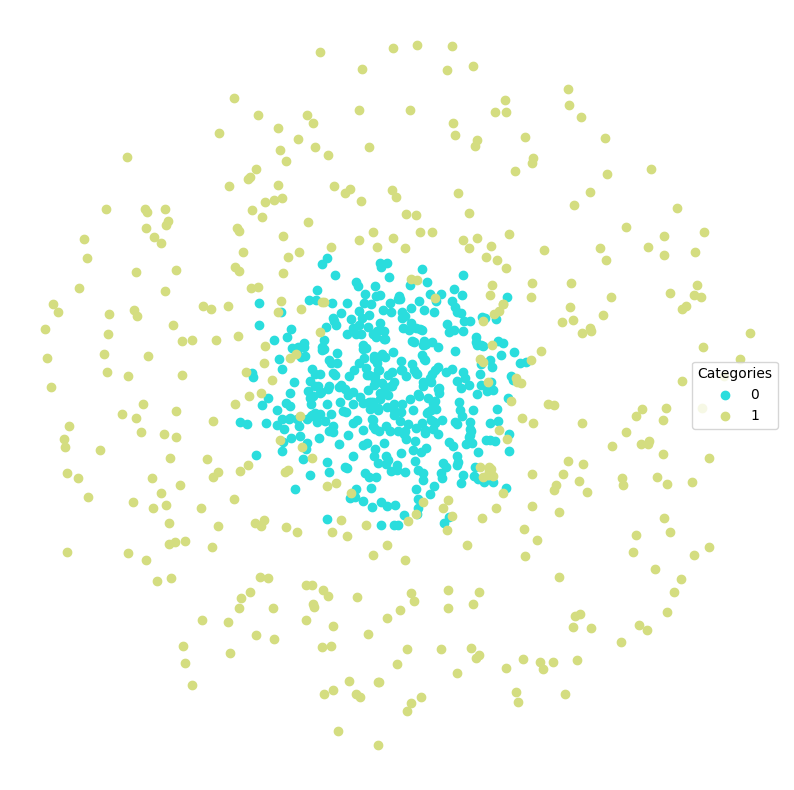

GaussianNB()           Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0               0.04  0.96285   0.926316           0.920908  0.988764
1               0.04  0.96285   0.990476           0.963014  0.936937
SVC(kernel='linear', probability=True)           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.42  0.621622   0.514451           0.514451  1.000000
1               0.42  0.621622   1.000000           0.663243  0.243243


SVC(kernel='poly', probability=True)           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.495  0.554054   0.473404           0.473404  1.000000
1              0.495  0.554054   1.000000           0.603108  0.108108
KNeighborsClassifier(weights='distance')           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.085  0.917856   0.875000           0.850843  0.943820
1              0.085  0.917856   0.951923           0.909012  0.891892
LogisticRegression()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.415  0.622786   0.518072           0.515609  0.966292
1              0.415  0.622786   0.911765           0.654637  0.279279
DecisionTreeClassifier()           Error_Rate    

/Users/dan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.07  0.935823   0.871287           0.866497  0.988764
1               0.07  0.935823   0.989899           0.938965  0.882883
GradientBoostingClassifier()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.065  0.936988   0.904255           0.883615  0.955056
1              0.065  0.936988   0.962264           0.929243  0.918919


/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


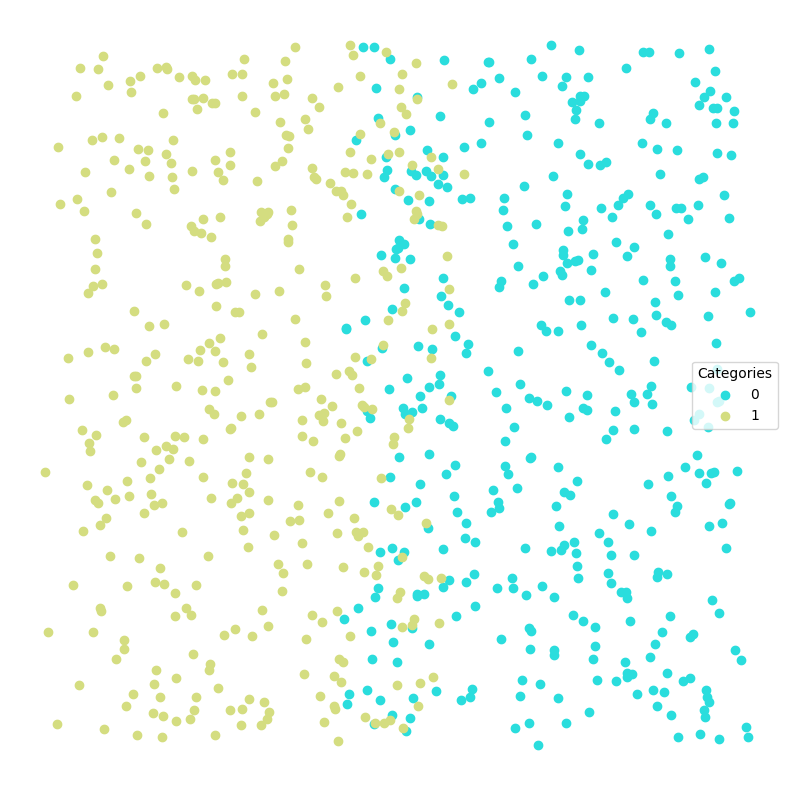

GaussianNB()           Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0               0.13  0.86859   0.888889           0.820741  0.833333
1               0.13  0.86859   0.854545           0.822378  0.903846
SVC(kernel='linear', probability=True)           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.135  0.863782   0.879121           0.812601  0.833333
1              0.135  0.863782   0.853211           0.817968  0.894231
SVC(kernel='poly', probability=True)           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.135  0.866987   0.822430           0.793894  0.916667
1              0.135  0.866987   0.913978           0.842002  0.817308
KNeighborsClassifier(weights='distance')           Error_Rate  

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


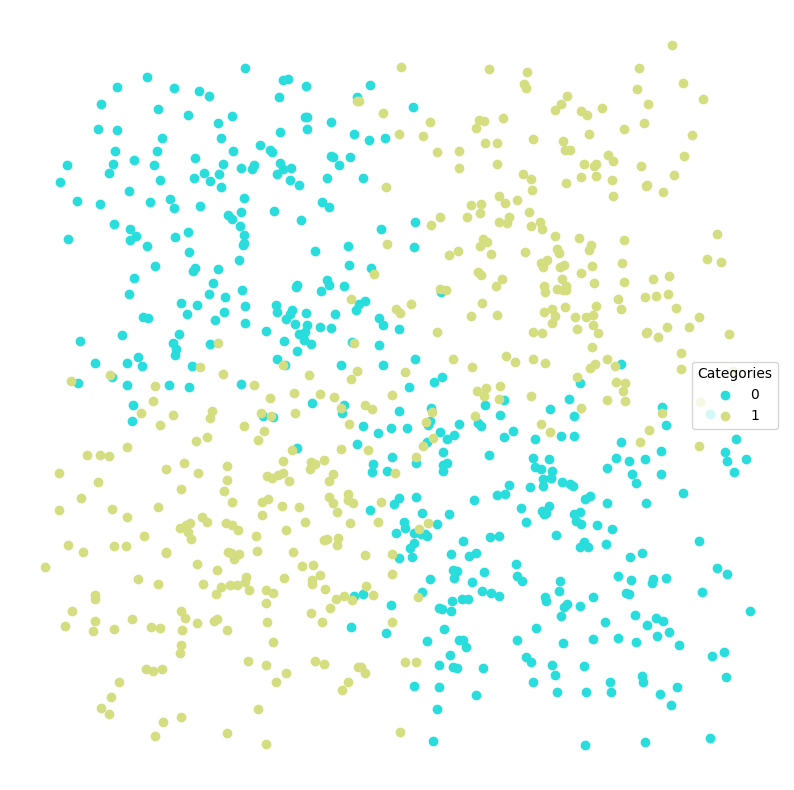

GaussianNB()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.485  0.515314   0.500000           0.492887  0.525773
1              0.485  0.515314   0.530612           0.522882  0.504854
SVC(kernel='linear', probability=True)           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.555  0.446452   0.436364           0.460933  0.494845
1              0.555  0.446452   0.455556           0.491338  0.398058
SVC(kernel='poly', probability=True)           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.26  0.736463      0.800           0.679845  0.618557
1               0.26  0.736463      0.704           0.676476  0.854369
KNeighborsClassifier(weights='distance')           Error_Ra

/Users/dan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.06  0.939646   0.947368           0.914002  0.927835
1               0.06  0.939646   0.933333           0.913026  0.951456
GradientBoostingClassifier()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.075  0.924782   0.927083           0.890623  0.917526
1              0.075  0.924782   0.923077           0.895344  0.932039


/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


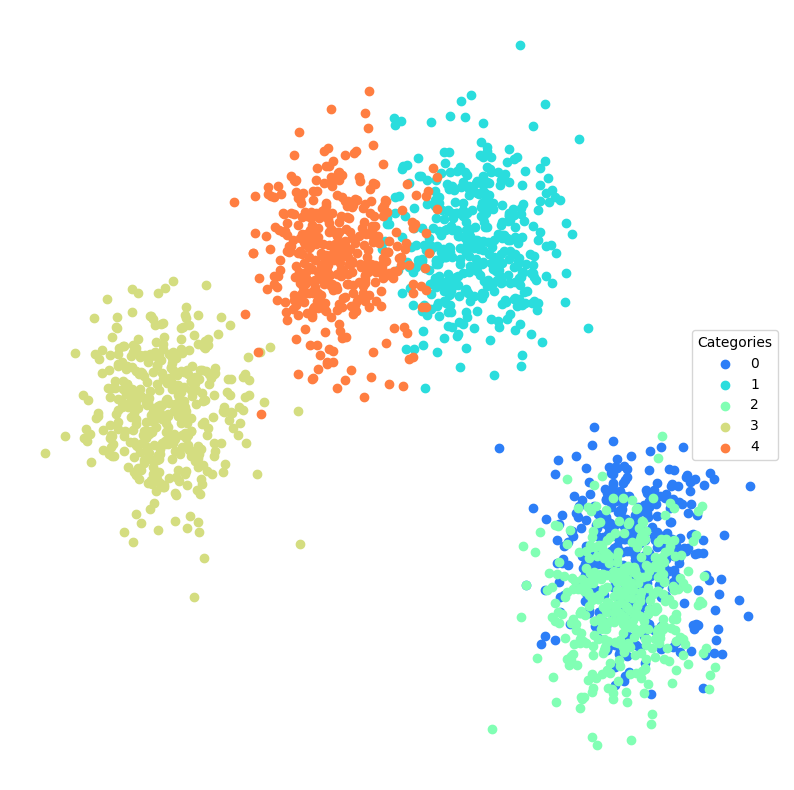

GaussianNB()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.130  0.801436   0.591837           0.463573  0.698795
1              0.016  0.972174   0.970588           0.933925  0.951923
2              0.130  0.796423   0.754902           0.576816  0.658120
3              0.002  0.998753   0.990000           0.990000  1.000000
4              0.018  0.973178   0.948980           0.917846  0.958763
SVC(kernel='linear', probability=True)           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.128  0.788160   0.604396           0.456503  0.662651
1              0.016  0.972174   0.970588           0.933925  0.951923
2              0.128  0.809600   0.743119           0.586467  0.692308
3              0.004  0.997506   0.980198           0.980198  1.000000
4              0.020  0.9

/Users/dan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.126  0.803834   0.604167           0.472189  0.698795
1              0.016  0.972174   0.970588           0.933925  0.951923
2              0.126  0.804970   0.759615           0.588903  0.675214
3              0.004  0.997506   0.980198           0.980198  1.000000
4              0.020  0.968023   0.948454           0.909564  0.948454
DecisionTreeClassifier()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.144  0.773742   0.556701           0.420191  0.650602
1              0.024  0.960033   0.950980           0.900972  0.932692
2              0.142  0.779686   0.725490           0.544857  0.632479
3              0.012  0.988715   0.951456           0.943846  0.989899
4              0.034  0.943683 

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


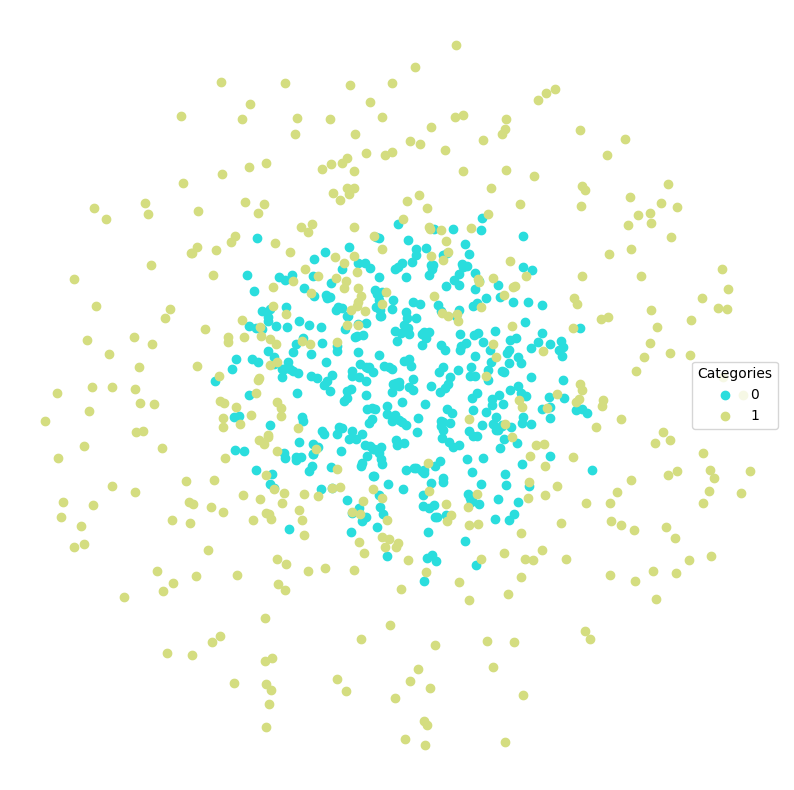

GaussianNB()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.195  0.804074   0.815217           0.740323  0.773196
1              0.195  0.804074   0.796296           0.749869  0.834951
SVC(kernel='linear', probability=True)           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.42  0.585927   0.546763           0.533391  0.783505
1               0.42  0.585927   0.655738           0.569655  0.388350
SVC(kernel='poly', probability=True)           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.445  0.567961   0.521505           0.521505  1.000000
1              0.445  0.567961   1.000000           0.580922  0.135922
KNeighborsClassifier(weights='distance')           Error_Ra

/Users/dan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0                0.2  0.799219   0.806452           0.733545  0.773196
1                0.2  0.799219   0.794393           0.745567  0.825243
GradientBoostingClassifier()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.175  0.825593   0.803922           0.754604  0.845361
1              0.175  0.825593   0.846939           0.782485  0.805825


/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


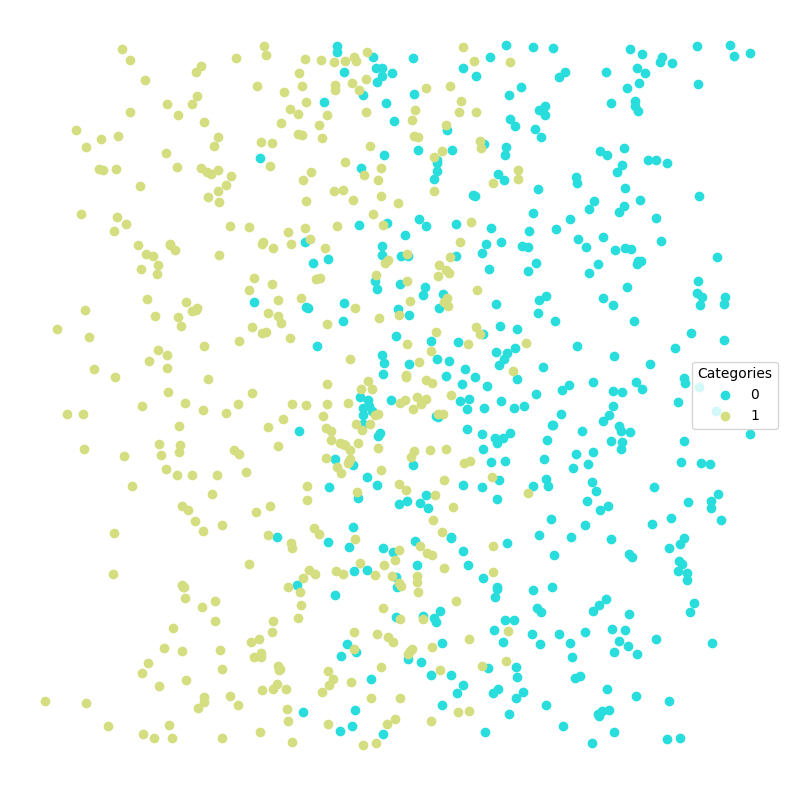

GaussianNB()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.22  0.780512   0.802083           0.730494  0.754902
1               0.22  0.780512   0.759615           0.707343  0.806122
SVC(kernel='linear', probability=True)           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.22  0.780712   0.808511           0.732420  0.745098
1               0.22  0.780712   0.754717           0.706095  0.816327
SVC(kernel='poly', probability=True)           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.17  0.832333   0.935897           0.814809  0.715686
1               0.17  0.832333   0.762295           0.748402  0.948980
KNeighborsClassifier(weights='distance')           Error_Ra

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


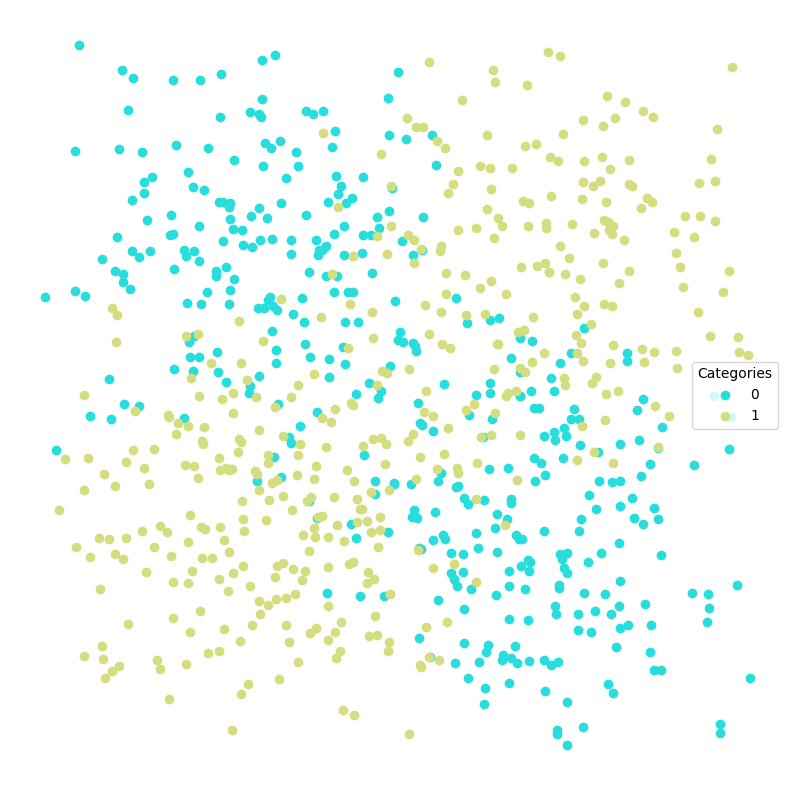

GaussianNB()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.585  0.453209    0.45000           0.546681  0.159292
1              0.585  0.453209    0.40625           0.413520  0.747126


/Users/dan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC(kernel='linear', probability=True)           Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0              0.565  0.5      0.000              0.565     0.0
1              0.565  0.5      0.435              0.435     1.0
SVC(kernel='poly', probability=True)           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.25  0.773472   0.943662           0.789516  0.592920
1               0.25  0.773472   0.643411           0.633829  0.954023
KNeighborsClassifier(weights='distance')           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.215  0.793866   0.872340           0.788026  0.725664
1              0.215  0.793866   0.707547           0.669954  0.862069
LogisticRegression()           Error_Rate       AUC  Precis

/Users/dan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.16  0.841217   0.878505           0.825791  0.831858
1               0.16  0.841217   0.795699           0.741801  0.850575
GradientBoostingClassifier()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0                0.2  0.805818   0.868687           0.796125  0.761062
1                0.2  0.805818   0.732673           0.688193  0.850575


/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


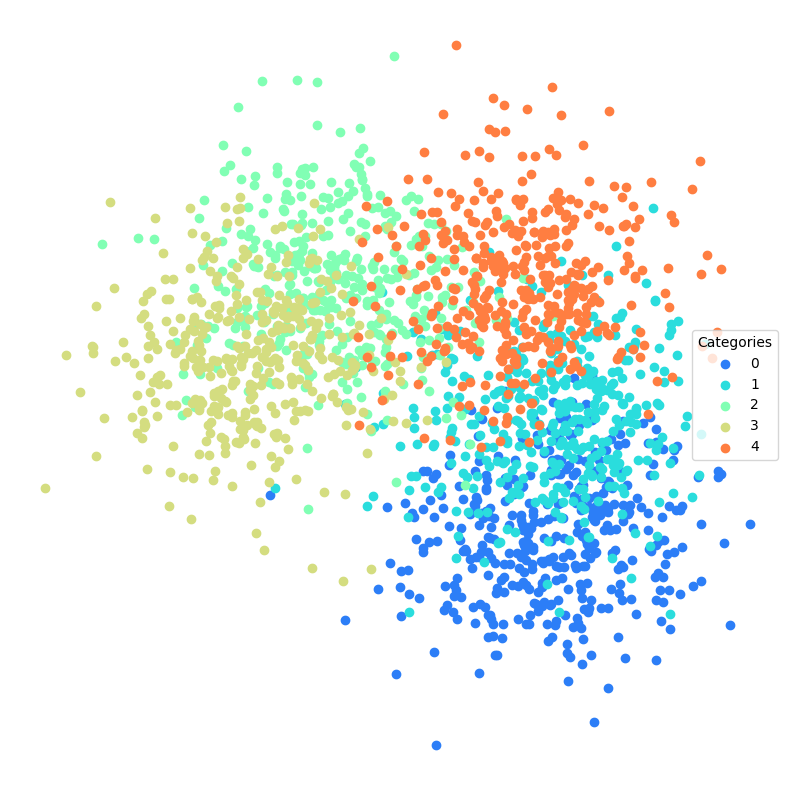

GaussianNB()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.074  0.879729   0.812500           0.691351  0.804124
1              0.122  0.801546   0.708333           0.542898  0.673267
2              0.120  0.824981   0.703704           0.570245  0.730769
3              0.082  0.858323   0.842105           0.687551  0.754717
4              0.086  0.884165   0.733333           0.643768  0.836957
SVC(kernel='linear', probability=True)           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.074  0.879729   0.812500           0.691351  0.804124
1              0.118  0.807750   0.718750           0.555027  0.683168
2              0.122  0.816628   0.704762           0.561465  0.711538
3              0.084  0.860502   0.826531           0.681594  0.764151
4              0.082  0.8

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


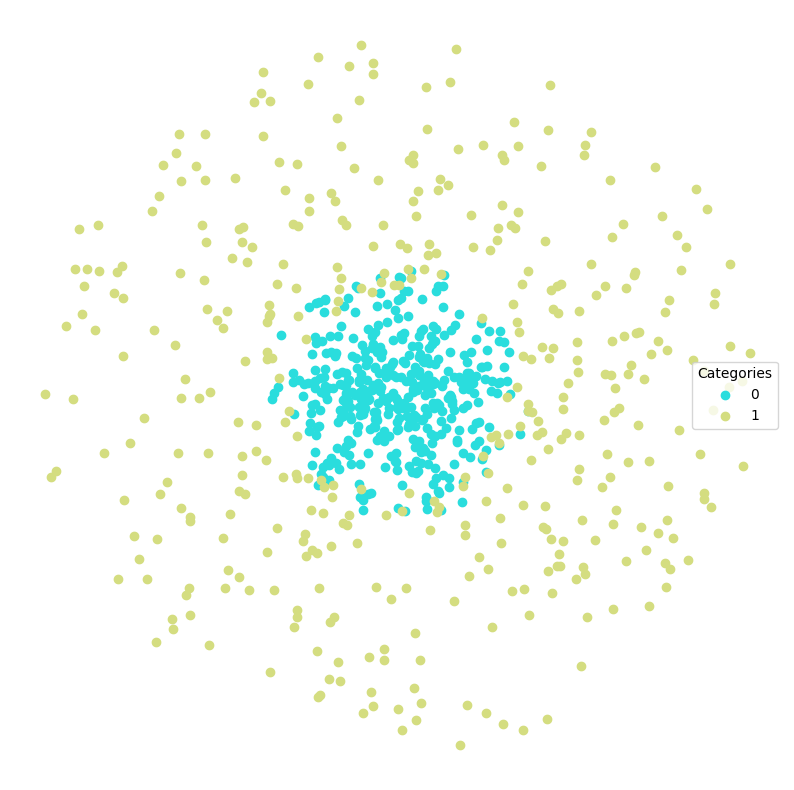

GaussianNB()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.065  0.935074   0.940594           0.911043  0.931373
1              0.065  0.935074   0.929293           0.902397  0.938776
SVC(kernel='linear', probability=True)           Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0               0.32  0.67487   0.625000           0.617108  0.931373
1               0.32  0.67487   0.854167           0.642355  0.418367
SVC(kernel='poly', probability=True)           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.405  0.586735   0.557377           0.557377  1.000000
1              0.405  0.586735   1.000000           0.578469  0.173469
KNeighborsClassifier(weights='distance')           Error_Rate  

/Users/dan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.065  0.934674   0.923810           0.903525  0.950980
1              0.065  0.934674   0.947368           0.910032  0.918367
GradientBoostingClassifier()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.06  0.940176       0.95           0.919804  0.931373
1               0.06  0.940176       0.93           0.907551  0.948980


/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


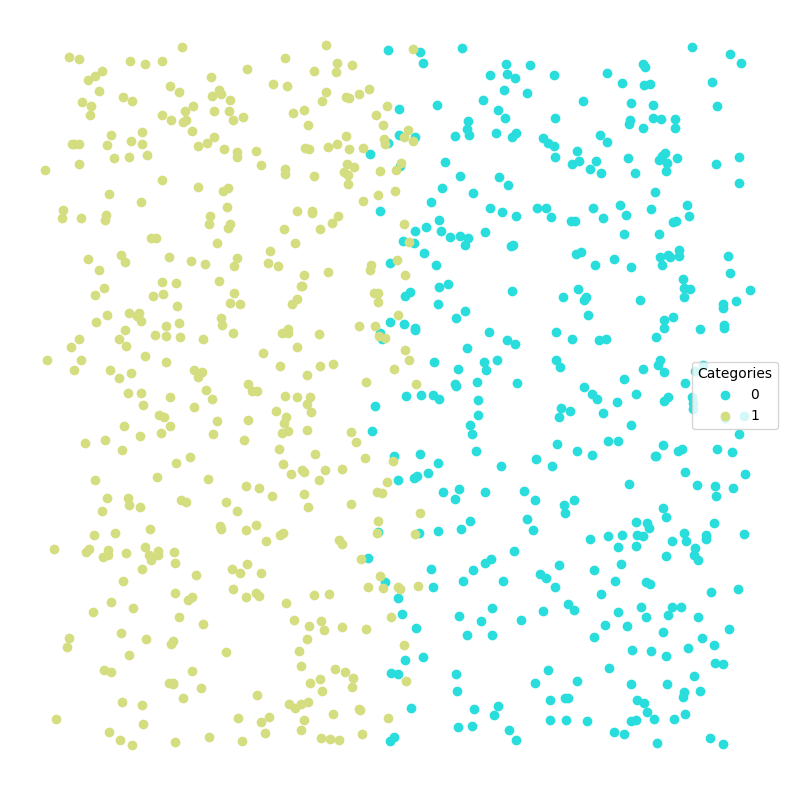

GaussianNB()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.055  0.945997   0.962963           0.937236  0.936937
1              0.055  0.945997   0.923913           0.902389  0.955056
SVC(kernel='linear', probability=True)           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.055  0.945997   0.962963           0.937236  0.936937
1              0.055  0.945997   0.923913           0.902389  0.955056
SVC(kernel='poly', probability=True)           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.045  0.952779   0.947368           0.936764  0.972973
1              0.045  0.952779   0.965116           0.930052  0.932584
KNeighborsClassifier(weights='distance')           Error_Ra

/Users/dan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.05  0.949388   0.954955           0.936939  0.954955
1               0.05  0.949388   0.943820           0.915797  0.943820
GradientBoostingClassifier()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.055  0.945997   0.962963           0.937236  0.936937
1              0.055  0.945997   0.923913           0.902389  0.955056


/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


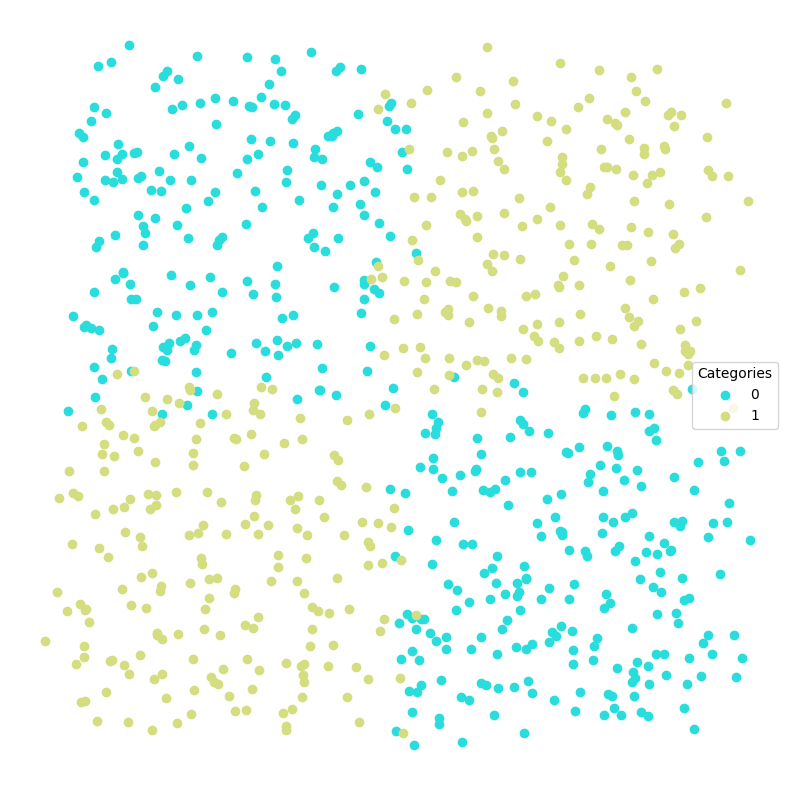

GaussianNB()           Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0                0.6  0.43376   0.380952           0.395980  0.658824
1                0.6  0.43376   0.452830           0.549504  0.208696


/Users/dan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC(kernel='linear', probability=True)           Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0              0.575  0.5      0.425              0.425     1.0
1              0.575  0.5      0.000              0.575     0.0
SVC(kernel='poly', probability=True)           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.415  0.600767   0.508475           0.483923  0.705882
1              0.415  0.600767   0.695122           0.634539  0.495652
KNeighborsClassifier(weights='distance')           Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0              0.065  0.93734   0.900000           0.877647  0.952941
1              0.065  0.93734   0.963636           0.933221  0.921739
LogisticRegression()           Error_Rate       AUC  Precision 

/Users/dan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.055  0.944501   0.930233           0.900513  0.941176
1              0.055  0.944501   0.956140           0.936255  0.947826
GradientBoostingClassifier()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.07  0.929923   0.908046           0.873949  0.929412
1               0.07  0.929923   0.946903           0.921031  0.930435


/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


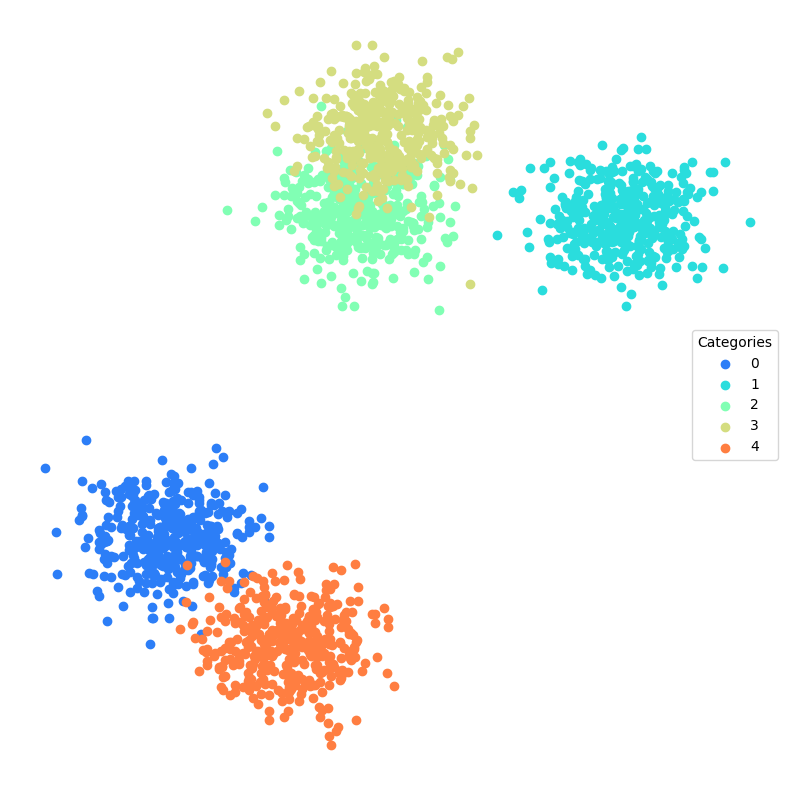

GaussianNB()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.008  0.987108   0.979167           0.962767  0.979167
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.044  0.929094   0.885417           0.805963  0.885417
3              0.044  0.932748   0.893204           0.819813  0.893204
4              0.008  0.988420   0.981982           0.968289  0.981982
SVC(kernel='linear', probability=True)           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.008  0.987108   0.979167           0.962767  0.979167
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.046  0.923886   0.884211           0.797684  0.875000
3              0.046  0.931489   0.884615           0.812142  0.893204
4              0.008  0.9

/Users/dan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.008  0.987108   0.979167           0.962767  0.979167
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.044  0.933065   0.877551           0.806139  0.895833
3              0.044  0.929153   0.900990           0.820020  0.883495
4              0.008  0.988420   0.981982           0.968289  0.981982
DecisionTreeClassifier()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.014  0.983395   0.949495           0.933714  0.979167
1              0.002  0.998768   0.989474           0.989474  1.000000
2              0.054  0.910994   0.863158           0.765281  0.854167
3              0.056  0.914407   0.864078           0.774630  0.864078
4              0.014  0.974907 

In [192]:
for i in range(12):
    dfTrain = globals()['dfTrain' + str(i)]
    dfTest = globals()['dfTest' + str(i)]
    lucem_illud.plotter(dfTrain)
    for i in range(9):
        clf = globals()['clf' + str(i)]
        clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
        print(clf, lucem_illud.evaluateClassifier(clf, dfTest))

This lets us look at which classes do better:

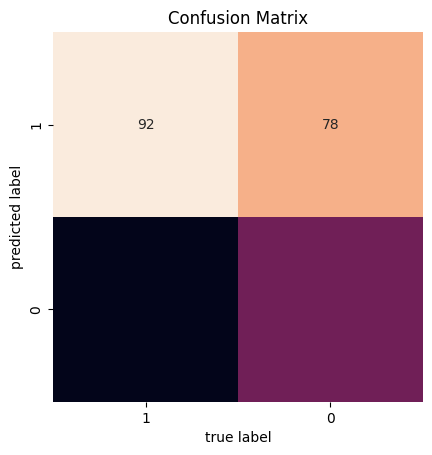

In [112]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

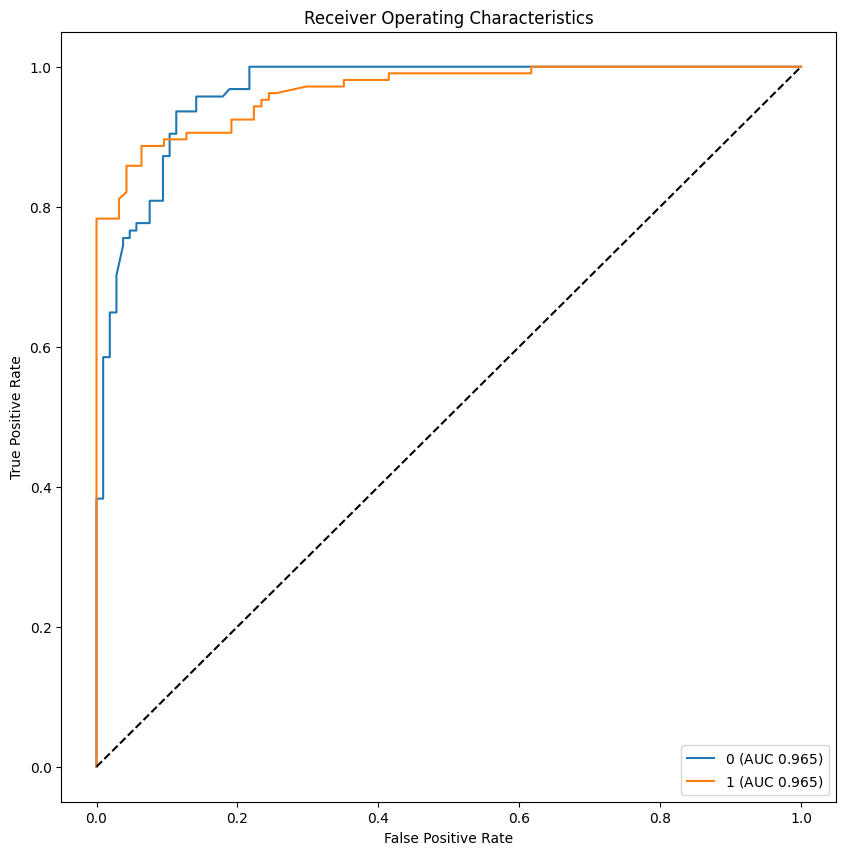

In [147]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


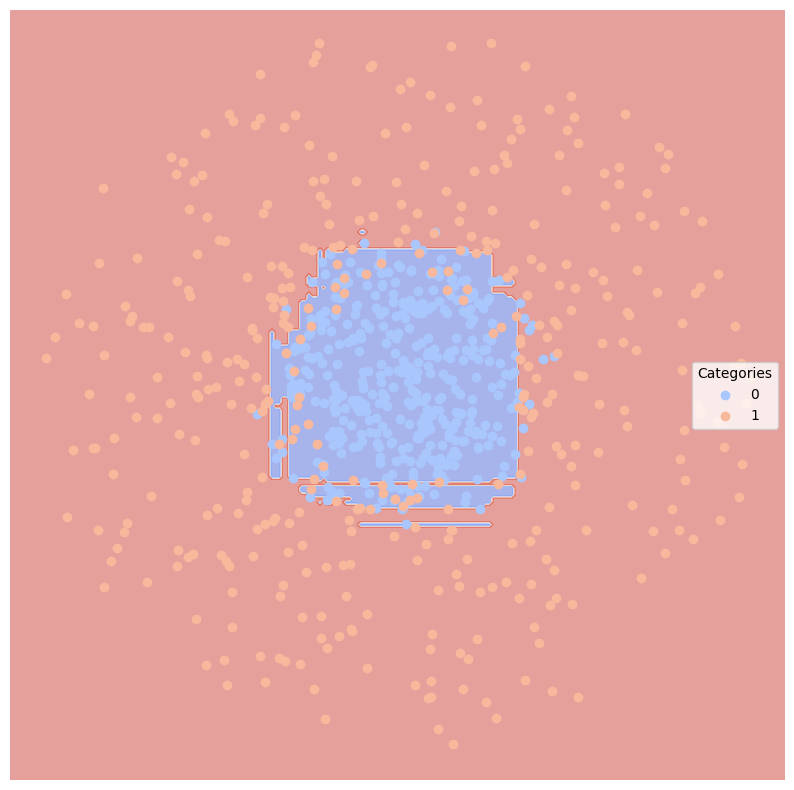

In [148]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

Note that if you're on Google Colab and have not `git clone`ed the [class repo](https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter), you can set a `dataDirectory=` parameter in the loadReddit function to match the data folder path on Colab.

In [150]:
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(dataDirectory='../data/'), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(dataDirectory=''), test_size=.2)

Loading Reddit data
Converting to vectors


/Users/dan/anaconda3/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [193]:
dfTrain1, dfTest1 = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)
dfTrain2, dfTest2 = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(), test_size=.2)
dfTrain3, dfTest3 = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(), test_size=.2)
dfTrain4, dfTest4 = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(), test_size=.2)

Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors


/Users/dan/anaconda3/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Loading senate data
Converting to vectors


/Users/dan/anaconda3/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Loading senator: Klobuchar
Loading senator: Kyl
Loading senator: Kerry
Loading senator: Kohl
Loading senator: Kennedy
Converting to vectors


/Users/dan/anaconda3/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Loading Spam
Loading Ham
Converting to vectors


/Users/dan/anaconda3/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [194]:
dfTrain1

,text,category,source_file,tokenized_text,normalized_text,vect
1009,"\n\n\nBegging everyone's pardon, I was not sla...",comp.windows.x,../data\20news_home\20news-bydate-train\comp.w...,"[Begging, everyone, 's, pardon, I, was, not, s...","[begging, pardon, slamming, motif, necessarily...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
404,"Well, here are the results of the Mathematica ...",comp.sys.mac.hardware,../data\20news_home\20news-bydate-train\comp.s...,"[Well, here, are, the, results, of, the, Mathe...","[results, mathematica, test, posted, newsgroup...","[0.0, 0.0, 0.1324660447169285, 0.0, 0.0, 0.0, ..."
1309,Comics for sale. All are Marvel and the majori...,misc.forsale,../data\20news_home\20news-bydate-train\misc.f...,"[Comics, for, sale, All, are, Marvel, and, the...","[comics, sale, marvel, majority, comics, cover...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
896,I am using the GLX widget + athena widgets on ...,comp.windows.x,../data\20news_home\20news-bydate-train\comp.w...,"[I, am, using, the, GLX, widget, +, athena, wi...","[glx, widget, +, athena, widgets, mixed, model...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1106,How can I obtain public information (documenta...,comp.windows.x,../data\20news_home\20news-bydate-train\comp.w...,"[How, can, I, obtain, public, information, doc...","[obtain, public, information, documentation, s...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
924,[ Article crossposted from hp.windows ]\n[ Aut...,comp.windows.x,../data\20news_home\20news-bydate-train\comp.w...,"[Article, crossposted, from, hp.windows, Autho...","[article, crossposted, hp.windows, author, and...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12560786..."
1831,Cup holders (driving is an importantant enough...,rec.autos,../data\20news_home\20news-bydate-train\rec.au...,"[Cup, holders, driving, is, an, importantant, ...","[cup, holders, driving, importantant, undertak...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
420,"Peter, I'm sure someone out there has a better...",comp.sys.mac.hardware,../data\20news_home\20news-bydate-train\comp.s...,"[Peter, I, 'm, sure, someone, out, there, has,...","[peter, m, sure, better, easier, way, want, te...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2014,"\n\n\nWell, if you want to stick the nose of y...",rec.autos,../data\20news_home\20news-bydate-train\rec.au...,"[Well, if, you, want, to, stick, the, nose, of...","[want, stick, nose, car, ass, foot, semi, supp...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [206]:
#Bayes
clf0 = sklearn.naive_bayes.GaussianNB()

#Analogizes
clf1 = sklearn.svm.SVC(kernel = 'linear', probability = False) #slow, set probability = False to speed up
clf2 = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = False) #slower
clf3 = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
clf4 = sklearn.linear_model.LogisticRegression()

#Symbolists
clf5 = sklearn.tree.DecisionTreeClassifier()
clf6 = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf7 = sklearn.neural_network.MLPClassifier() #extremely slow

#Ensemble
clf7 = sklearn.ensemble.GradientBoostingClassifier()

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


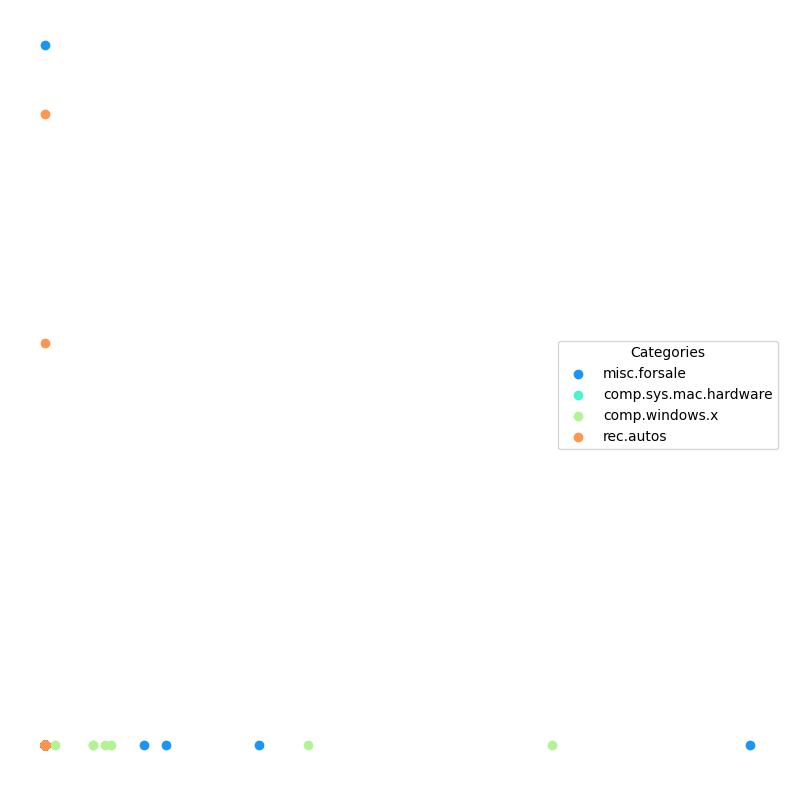

GaussianNB()                        Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
misc.forsale             0.127660  0.814360   0.754717           0.601966   
comp.sys.mac.hardware    0.114894  0.848383   0.762712           0.647078   
comp.windows.x           0.078723  0.915238   0.798450           0.744810   
rec.autos                0.087234  0.877538   0.863248           0.745160   

                         Recall  
Category                         
misc.forsale           0.701754  
comp.sys.mac.hardware  0.775862  
comp.windows.x         0.903509  
rec.autos              0.801587  
SVC(kernel='linear')                        Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
misc.forsale             0.068085  0.898408   0.879630           0.773450   
comp.sys.mac.hardware    0.068085  0.902640   0.875000           0.7

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


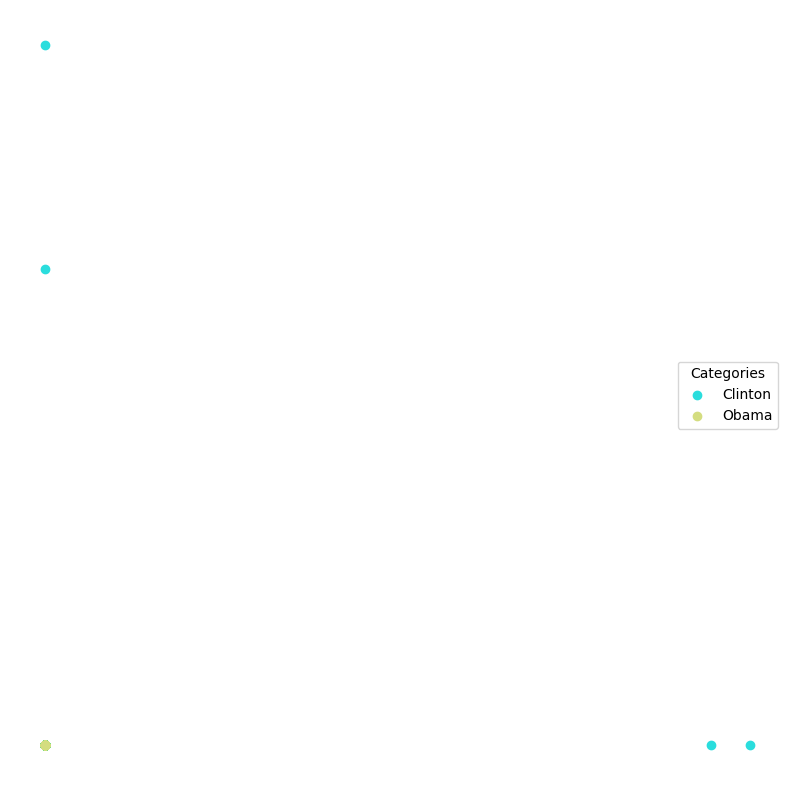

GaussianNB()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
Clinton     0.143275  0.841443   0.846154           0.827180  0.925743
Obama       0.143275  0.841443   0.876033           0.762697  0.757143
SVC(kernel='linear')           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
Clinton     0.002924  0.996429   0.995074           0.995074  1.000000
Obama       0.002924  0.996429   1.000000           0.995781  0.992857
SVC(kernel='poly')           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
Clinton     0.146199  0.826909    0.81405           0.808520  0.975248
Obama       0.146199  0.826909    0.95000           0.776222  0.678571
KNeighborsClassifier(weights='distance')           Error_Rate       AUC  Precision  Average_Pre

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


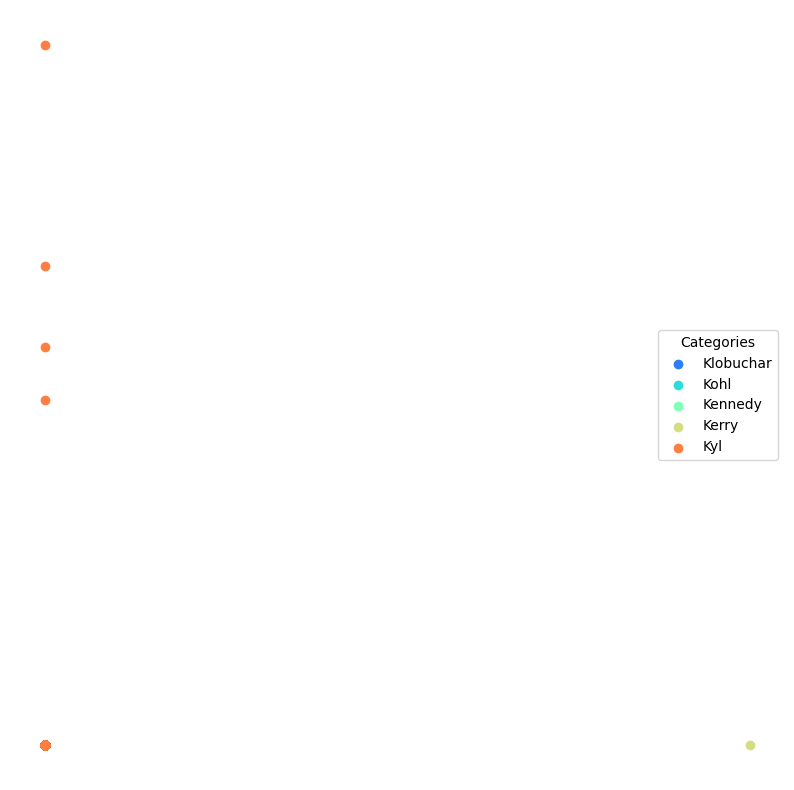

GaussianNB()            Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                               
Klobuchar    0.052497  0.754823   0.953488           0.538599  0.512500
Kohl         0.052497  0.718484   0.909091           0.449725  0.441176
Kennedy      0.267606  0.750469   0.638258           0.628943  0.949296
Kerry        0.147247  0.756292   0.765957           0.540380  0.568421
Kyl          0.074264  0.685335   0.916667           0.414173  0.375000
SVC(kernel='linear')            Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                               
Klobuchar    0.005122  0.975000   1.000000           0.955122  0.950000
Kohl         0.002561  0.991946   0.985294           0.972085  0.985294
Kennedy      0.017926  0.982160   0.977591           0.968751  0.983099
Kerry        0.012804  0.984398   0.968750           0.953477  0.978947
Kyl          0.000000  1.00000

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


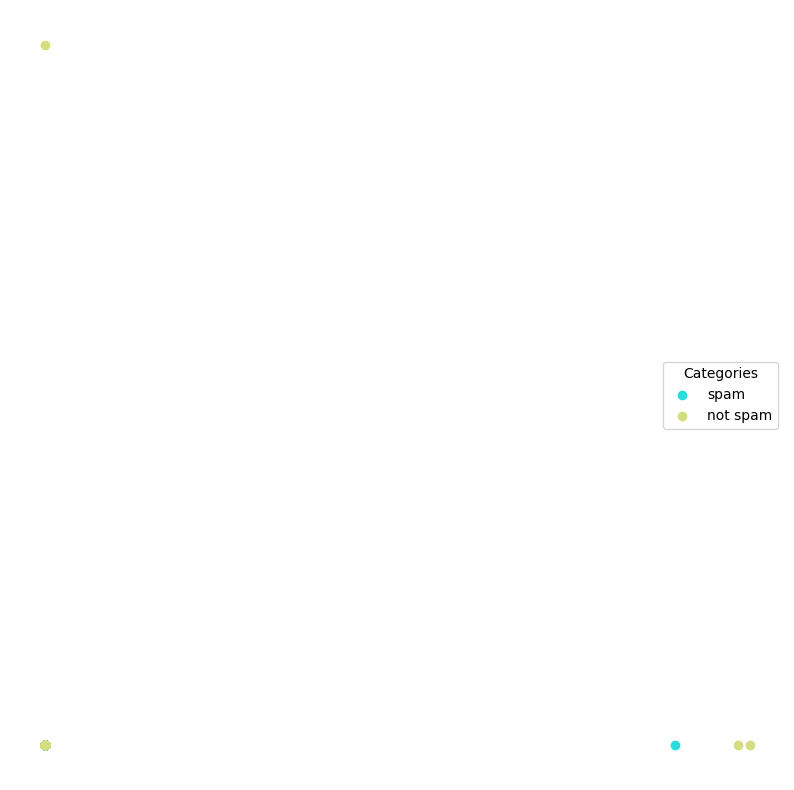

GaussianNB()           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
spam        0.138686  0.827807   0.503356           0.423904  0.781250
not spam    0.138686  0.827807   0.960821           0.948136  0.874363
SVC(kernel='linear')           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
spam        0.072993  0.770099   0.883333           0.550447  0.552083
not spam    0.072993  0.770099   0.931200           0.930352  0.988115
SVC(kernel='poly')           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
spam        0.080292  0.722261   0.955556           0.505382  0.447917
not spam    0.080292  0.722261   0.917188           0.916993  0.996604
KNeighborsClassifier(weights='distance')           Error_Rate       AUC  Precision  Average_Pre

In [207]:
for i in range(1, 5):
    dfTrain = globals()['dfTrain' + str(i)]
    dfTest = globals()['dfTest' + str(i)]
    lucem_illud.plotter(dfTrain)
    for i in range(8):
        clf = globals()['clf' + str(i)]
        clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
        print(clf, lucem_illud.evaluateClassifier(clf, dfTest))

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


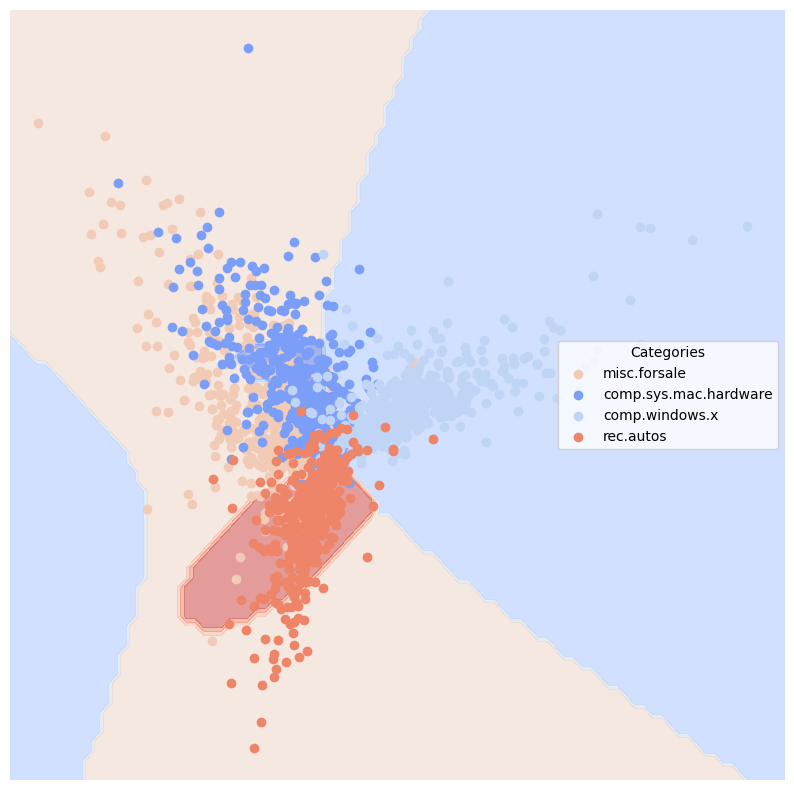

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


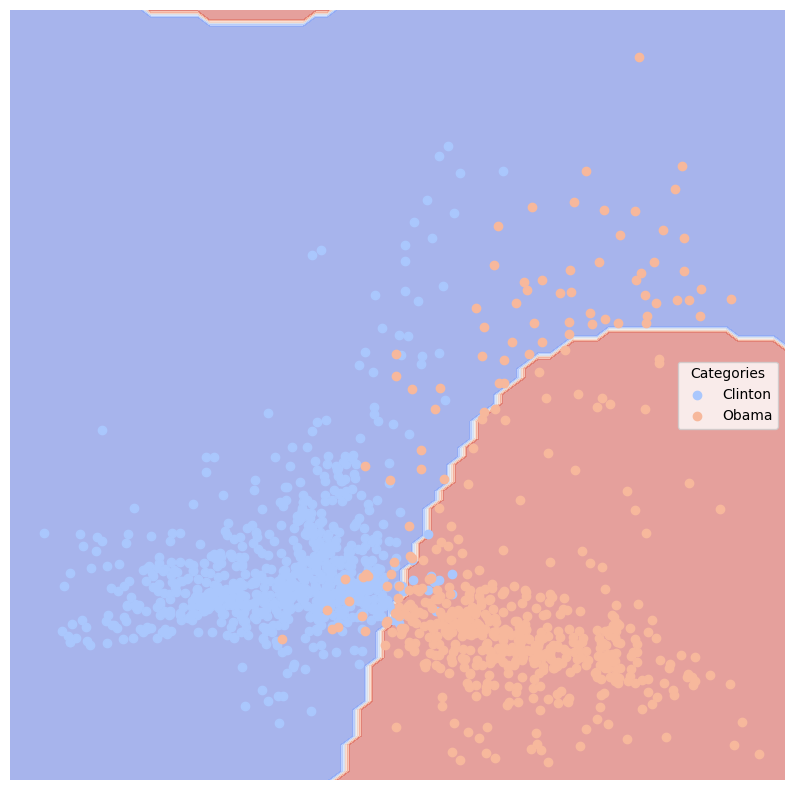

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


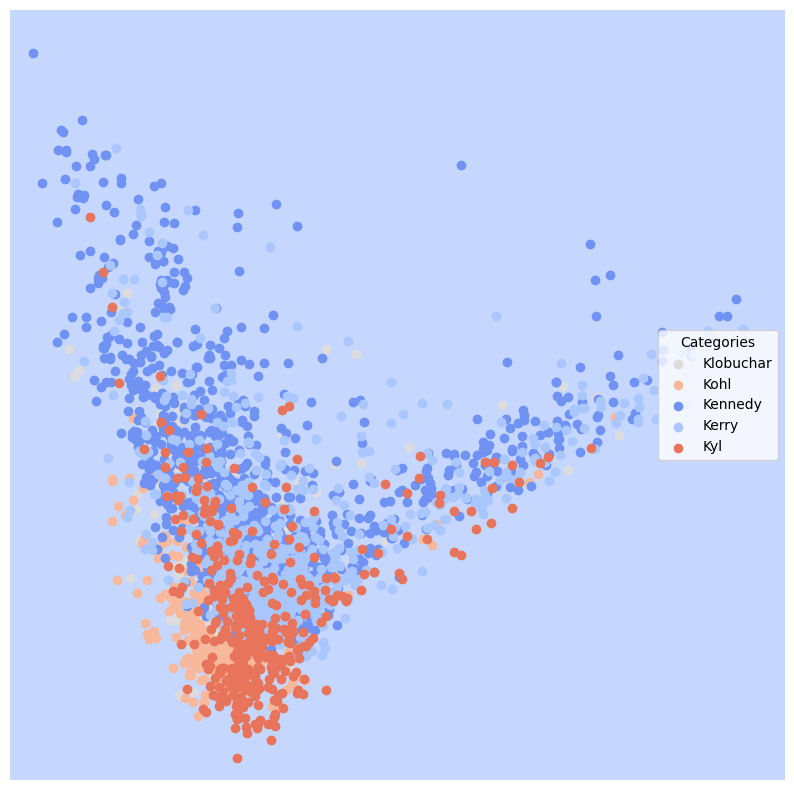

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


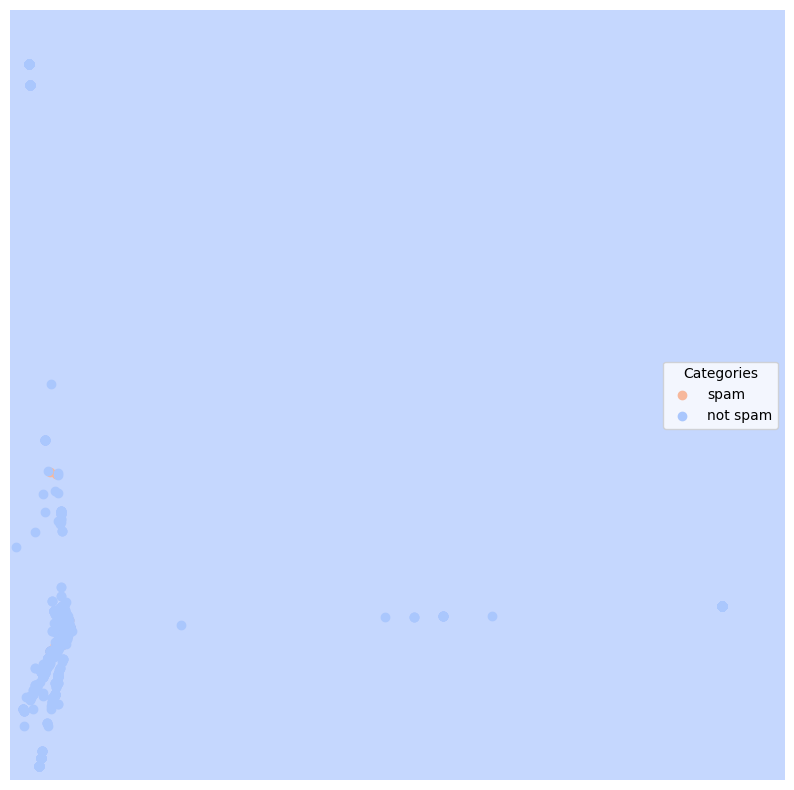

In [211]:
for i in range(1, 5):
    dfTrain = globals()['dfTrain' + str(i)]
    clf0.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
    lucem_illud.plotregions(clf0, dfTrain)

In [197]:
clf.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])

LogisticRegression()

In [198]:
lucem_illud.evaluateClassifier(clf, dfTest1)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
misc.forsale,0.061702,0.902622,0.904762,0.794394,0.833333
comp.sys.mac.hardware,0.063830,0.899669,0.905660,0.792065,0.827586
comp.windows.x,0.042553,0.948058,0.898305,0.852287,0.929825
rec.autos,0.061702,0.940245,0.843972,0.811978,0.944444


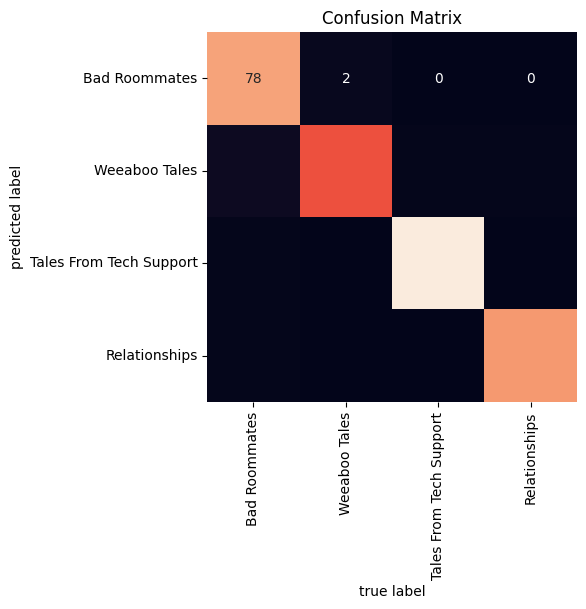

In [155]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

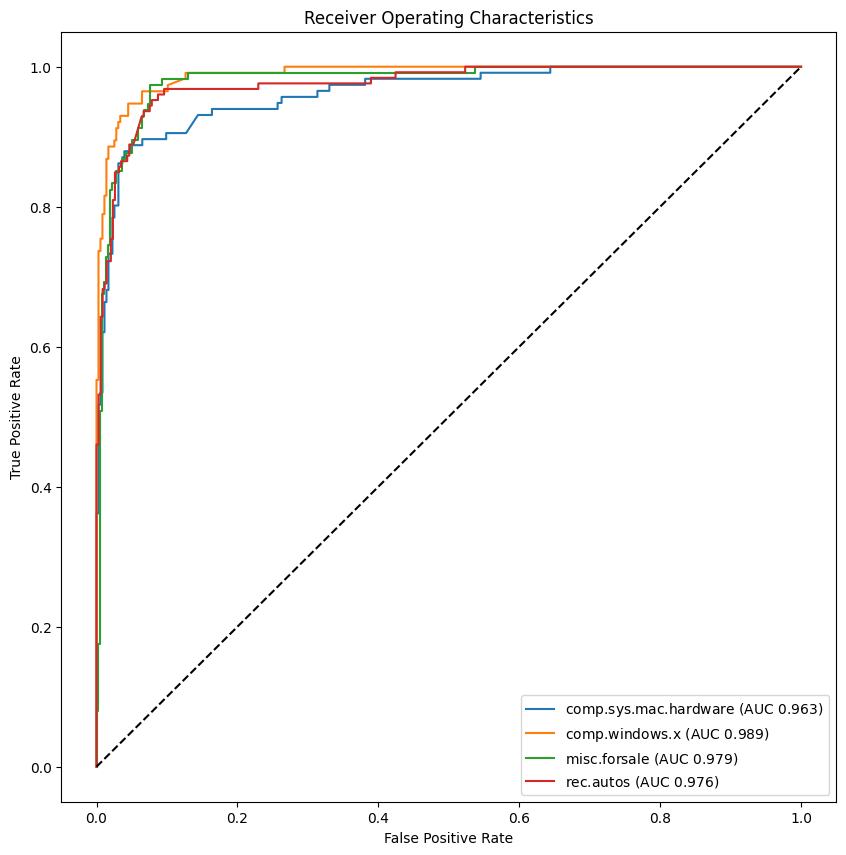

In [199]:
lucem_illud.plotMultiROC(clf, dfTest1)

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


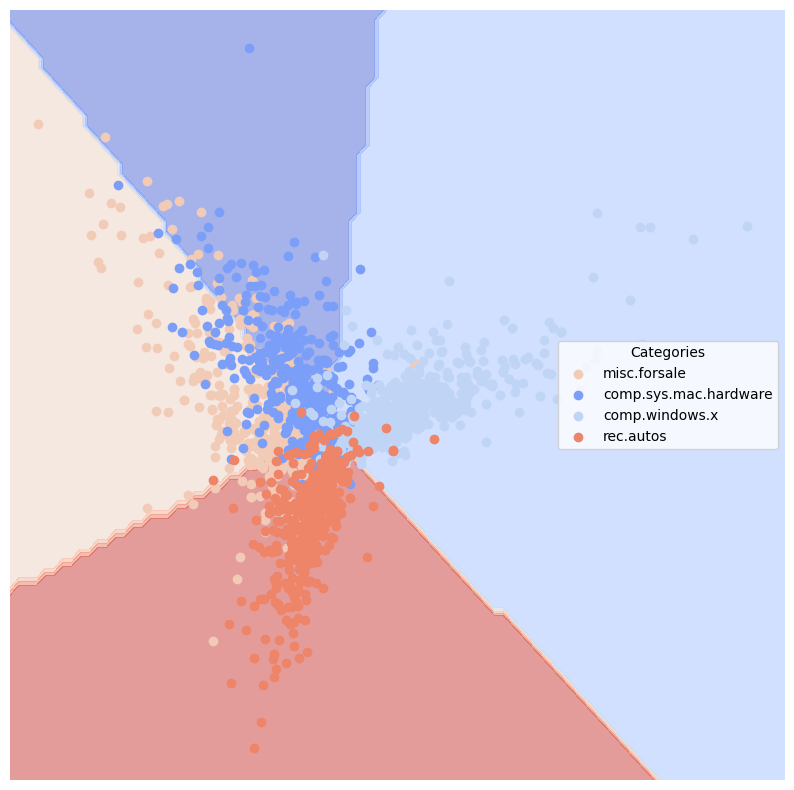

In [200]:
lucem_illud.plotregions(clf, dfTrain1)

## <font color="red">*Exercise 2*</font>

<font color="red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<font color="red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

Artificial:
- For target-based splitting, naive Bayes works quite well, as do nearest neighbors, decision tree, random forest, MLP, and gradient-boosting.
- For and splitting, all models perform fairly well, but SVC with polynomial-based kernel appears to do the best (gradient-boosting does better with low noise but SVC is better with high noise).
- For xor splitting, MLP performs the best.
- For multiblob splitting, it is difficult to determine the best model as scores vary widely between categories. Naive Bayes, both SVC models, logistic regression and MLP all perform well.

Experimental:
- I did not use MLP because it took too long.
- For newsgroups, linear SVC and logistic regression performed best.
-  For senate_small, linear SVC and random forest performed almost perfectly, while logistic regression, decision trees and gradient boosting also worked very well.
- For senate_large, linear SVC performed well again but was outperformed by decision tree, random forest and gradient boosting.
- For spam, naive Bayes and decision tree performed best.

In [212]:
from sklearn.ensemble import AdaBoostClassifier

In [214]:
dfTrain0, dfTest0 = sklearn.model_selection.train_test_split(targetSplit(noise), test_size=.2)
#dfTrain1, dfTest1 = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)


In [222]:
clf = AdaBoostClassifier(n_estimators=100, algorithm="SAMME",)
clf.fit(np.stack(dfTrain0['vect'], axis=0), dfTrain0['category'])

AdaBoostClassifier(algorithm='SAMME', n_estimators=100)

In [218]:
lucem_illud.evaluateClassifier(clf, dfTest0)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.075,0.923559,0.909091,0.890801,0.952381
1,0.075,0.923559,0.944444,0.895029,0.894737


/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


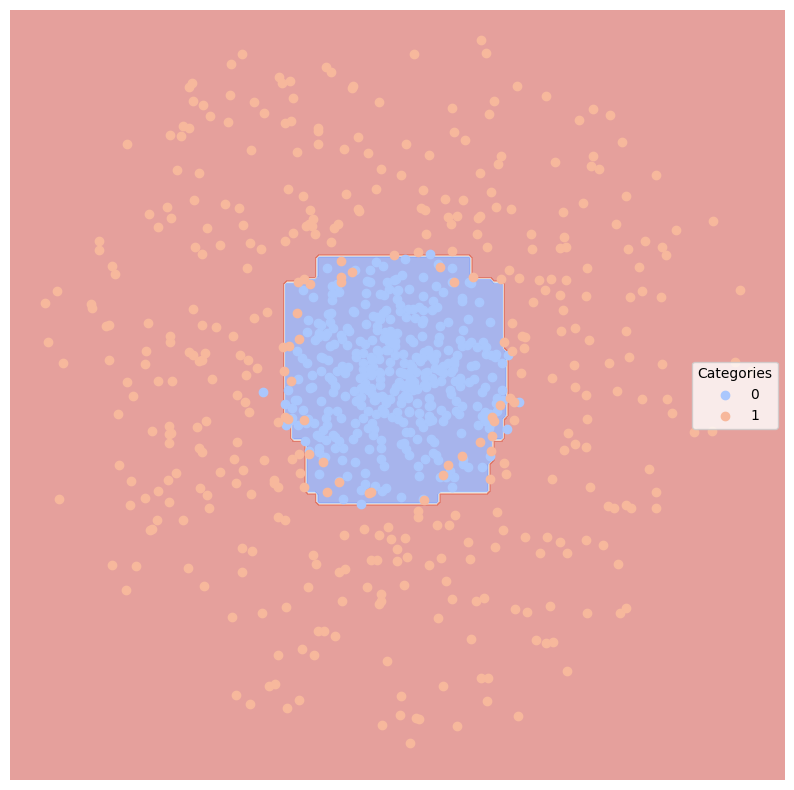

In [223]:
lucem_illud.plotregions(clf, dfTrain0)

In [219]:
clf.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])

AdaBoostClassifier(algorithm='SAMME', n_estimators=100)

In [220]:
lucem_illud.evaluateClassifier(clf, dfTest1)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
misc.forsale,0.095745,0.817539,0.936709,0.693145,0.649123
comp.sys.mac.hardware,0.257447,0.808811,0.488789,0.474187,0.939655
comp.windows.x,0.082979,0.870688,0.864078,0.727778,0.780702
rec.autos,0.151064,0.730828,0.923077,0.579986,0.476190


/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


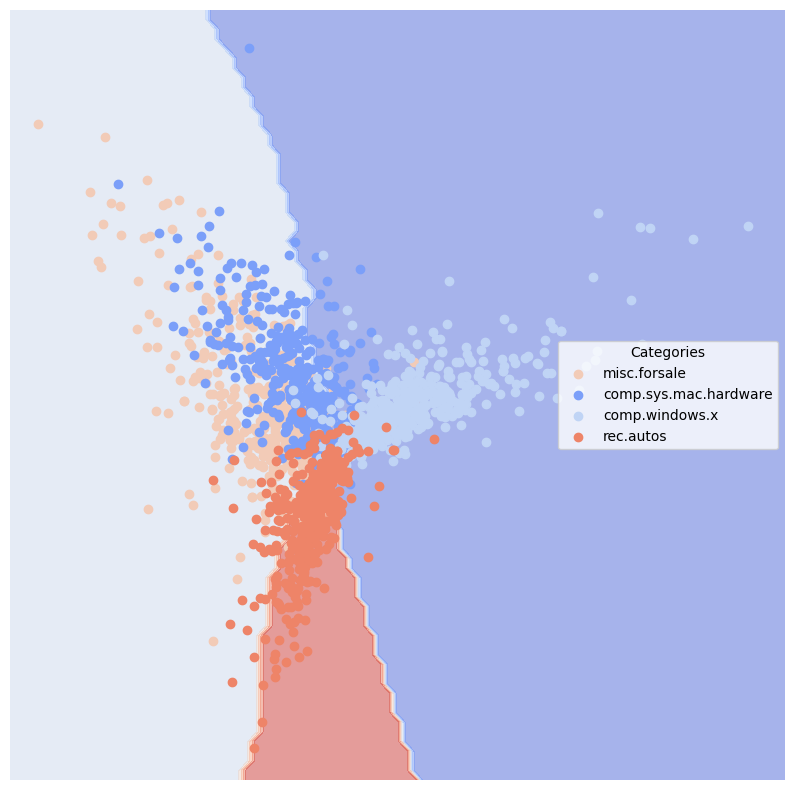

In [221]:
lucem_illud.plotregions(clf, dfTrain1)

- The AdaBoost classifier performs quite well on the artificial data set, on par with random forest, MLP and gradient boosting, though not quite as good as SVC or logistic.
- For the experimental data set its performance is more middle-of-the-pack. It seems to have trouble with certain categories, with a high error rate for hardware and autos, a low precision for hardware, and a low recall for forsale and autos.

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest?

In [7]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame.

In [225]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [228]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator,category
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama,True
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama,True
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama,True
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama,True
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama,True
...,...,...,...,...,...,...,...
1704,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton285.txt,raw/Clinton/1Sep2005Clinton285.txt,September 1 2005 Senator Clinton Visit Infoto...,Clinton,False
1705,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton286.txt,raw/Clinton/1Sep2005Clinton286.txt,September 1 2005 Senator Clinton Announces Ex...,Clinton,False
1706,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton287.txt,raw/Clinton/1Sep2005Clinton287.txt,September 1 2005 Senator Clinton Joins Local ...,Clinton,False
1707,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2006Clinton207.txt,raw/Clinton/1Sep2006Clinton207.txt,September 1 2006 Clintons Meet with Cazenovia...,Clinton,False


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [227]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [229]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/Users/dan/anaconda3/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Let's split the data into training data and testing data.

In [230]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(ObamaClintonReleases, test_size=holdBackFraction)

In [231]:
print(len(train_data_df))
print(len(test_data_df))

1367
342


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [232]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents.

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean?

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1.

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform.

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [233]:
TFVects.shape

(1367, 11362)

We can save this in the dataframe to make things easier

In [234]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [235]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [236]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

/var/folders/1w/6x7_f0pn7417tk3p1dnytgvm0000gn/T/ipykernel_42642/2339884988.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")
/var/folders/1w/6x7_f0pn7417tk3p1dnytgvm0000gn/T/ipykernel_42642/2339884988.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")


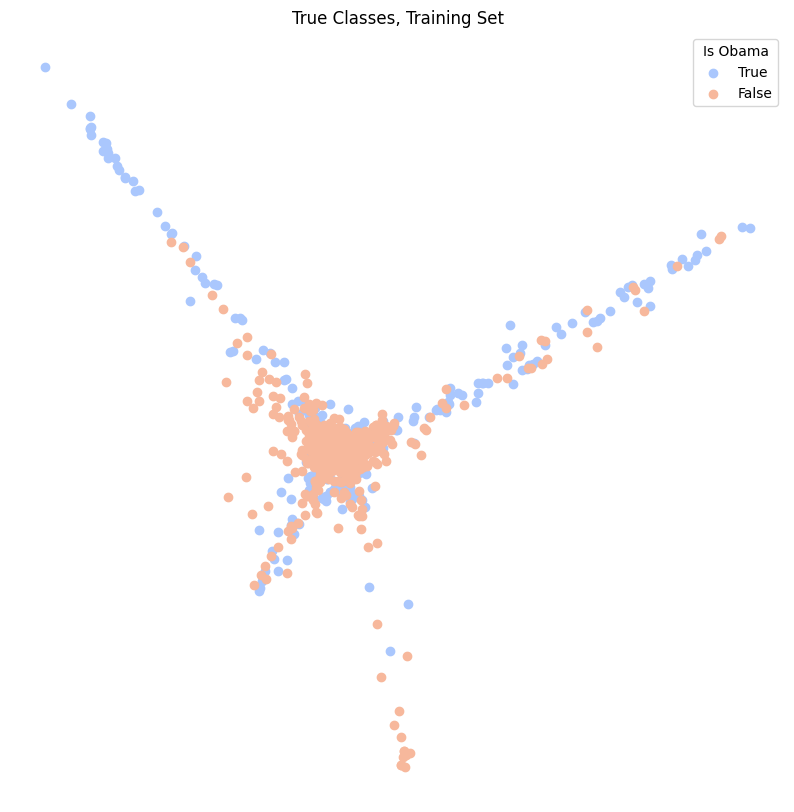

In [238]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")

ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

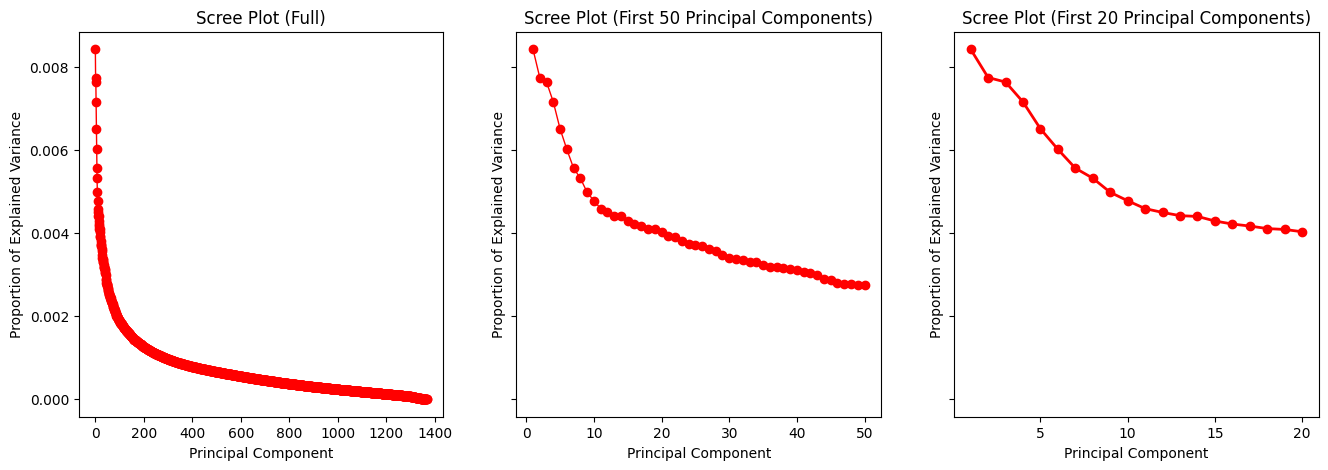

In [239]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 20 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [240]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [241]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [242]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6656912948061449

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [243]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6578947368421053

Slightly poorer. How about using more dimensions (40)?

In [244]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7329919531821507
Testing:
0.716374269005848


Or still more (100)?

In [245]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8288222384784198
Testing:
0.7923976608187134


Or even more (200)!

In [246]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8632040965618142
Testing:
0.8157894736842105


This is becoming ridiculous (400)!

In [247]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9063643013899049
Testing:
0.8187134502923976


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [ ]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

Train the model using training data, and then test it on the testing data.

In [ ]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

81% accuracy seems like the best we can get by using a logistic regression.

## <font color="red">*Exercise 3*</font>

<font color="red">In the cells immediately following, perform logistic regression classification using training, testing and uncoded (i.e., data you didn't code by hand but want to use your model on) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk in Exercise 1). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [64]:
def getPosts(dir):
    dict = {
        'filename': [],
        'text': []
    }
    files = os.listdir(dir)
    for file in files:
        with open(dir + file) as f:
            dict['filename'].append(file)
            dict['text'].append(f.read())

    return pd.DataFrame(dict)

In [65]:
import pandas as pd

In [103]:
nondepDir = "../../thesis/Identifying-depression/Data_Collector/reddit_non_depression/"
nondepPosts = getPosts(nondepDir)
nondepPosts['category'] = 0
depDir = "../../thesis/Identifying-depression/Data_Collector/reddit_depression/"
depPosts = getPosts(depDir)
depPosts = depPosts[:len(nondepPosts)]
depPosts['category'] = 1
allPosts = nondepPosts.append(depPosts, ignore_index=True)
allPosts

,filename,text,category
0,Breesasha.txt,Ending a 6 year friendship over her husband\n\...,0
1,jasmarie98.txt,"Went through tough times, friends weren't ther...",0
2,UnknownDude007.txt,Is there any chance of me being able to fix th...,0
3,Trumpeachment.txt,My dad is about to be 65. I'm scared suddenly ...,0
4,smoofsmooff.txt,I want to fix my best friend and I's friendshi...,0
...,...,...,...
1091,fufukuschlipups.txt,Even in objectively good circumstances I feel ...,1
1092,StrangeStep.txt,"Does anyone else ""live inside their head""?\nHi...",1
1093,MisterGiraffaxx.txt,My birthday is in 15 days.\nI have never felt ...,1
1094,Marleaubugatti.txt,Antidepressants for GAD\nAre any of you taking...,1


In [104]:
allPosts['tokenized_text'] = allPosts['text'].apply(lambda x: lucem_illud.word_tokenize(x))
allPosts['normalized_text'] = allPosts['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/Users/dan/anaconda3/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [105]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(allPosts, test_size=holdBackFraction)
print(len(train_data_df))
print(len(test_data_df))

876
220


In [106]:
train_data_df['category'] = train_data_df['category'] == 1
test_data_df['category'] = test_data_df['category'] == 1

In [109]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])
print(TFVects.shape)
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))
train_data_df['pca'] = [r for r in reduced_data]

(876, 4302)


/var/folders/1w/6x7_f0pn7417tk3p1dnytgvm0000gn/T/ipykernel_74558/2768478719.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")
/var/folders/1w/6x7_f0pn7417tk3p1dnytgvm0000gn/T/ipykernel_74558/2768478719.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")


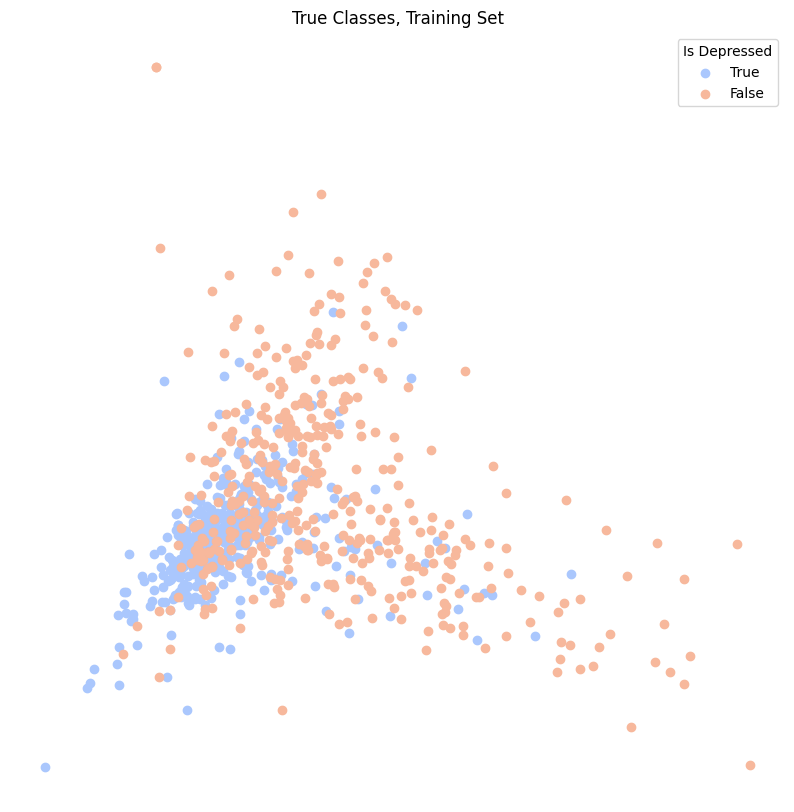

In [110]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")

ax.legend(loc = 'upper right', title = 'Is Depressed')
plt.title('True Classes, Training Set')
plt.show()

In [111]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
logistic.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

0.9668949771689498

In [113]:
TestVects = TFVectorizer.transform(test_data_df['text'])
print(TestVects.shape)
test_data_df['vect'] = [np.array(v).flatten() for v in TestVects.todense()]
logistic.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category'])

(220, 4302)


0.9090909090909091

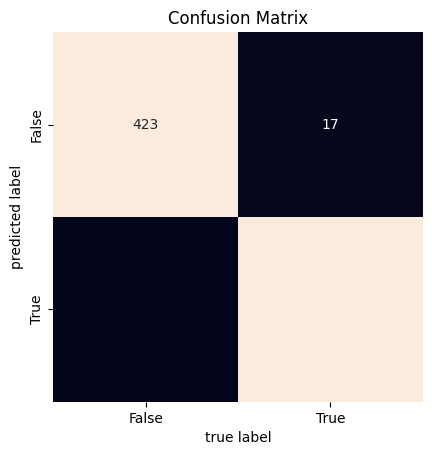

In [114]:
lucem_illud.plotConfusionMatrix(logistic, train_data_df)

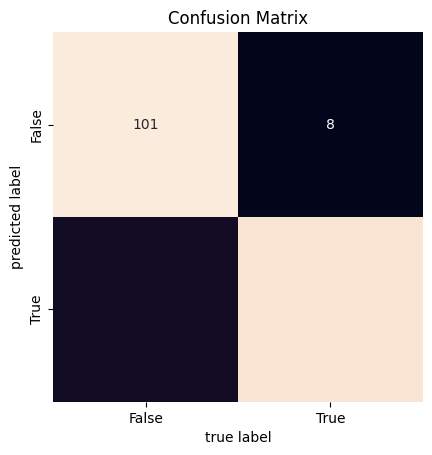

In [115]:
lucem_illud.plotConfusionMatrix(logistic, test_data_df)

In [116]:
lucem_illud.evaluateClassifier(logistic, train_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.033105,0.966933,0.961364,0.948542,0.972414
True,0.033105,0.966933,0.972477,0.954396,0.961451


In [117]:
lucem_illud.evaluateClassifier(logistic, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.090909,0.909519,0.926606,0.882750,0.893805
True,0.090909,0.909519,0.891892,0.861572,0.925234


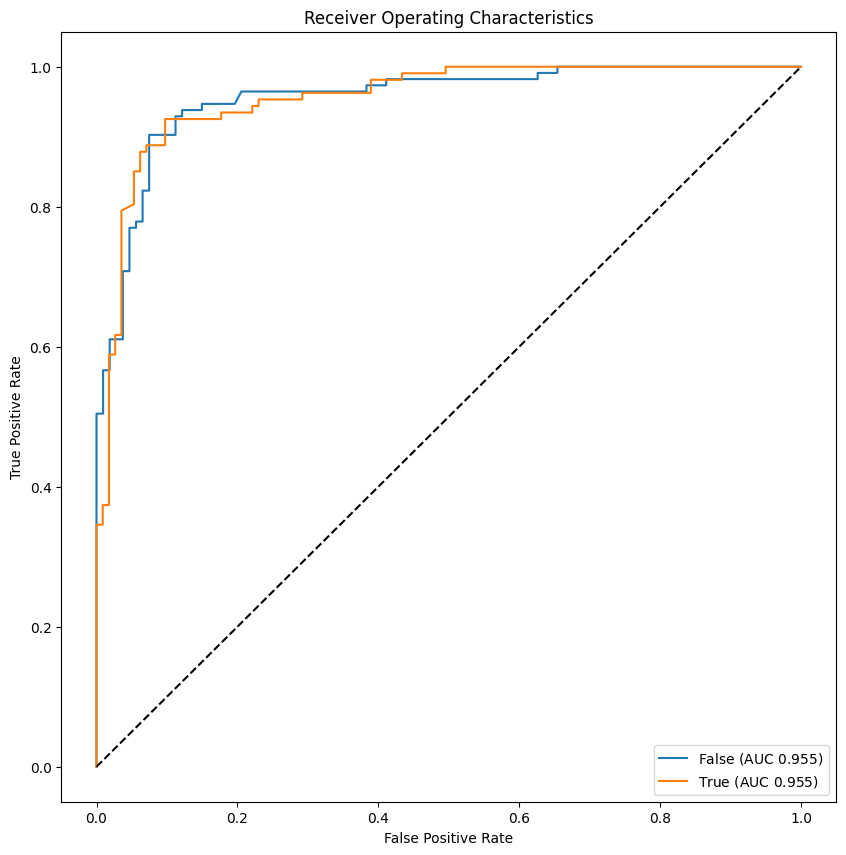

In [119]:
lucem_illud.plotMultiROC(logistic, test_data_df)

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


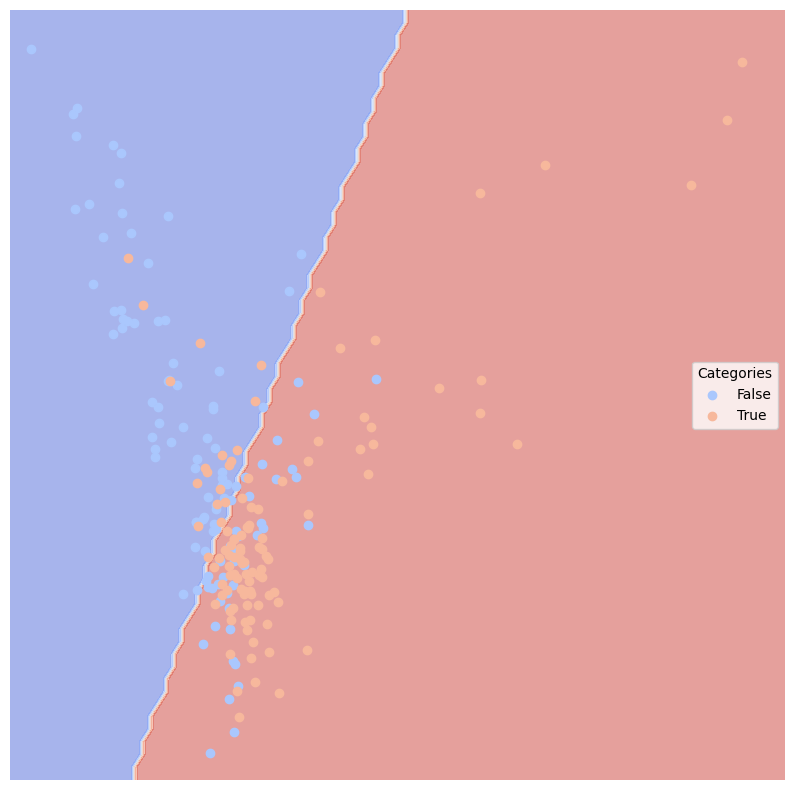

In [175]:
lucem_illud.plotregions(logistic, test_data_df)

- The logistic classifier fits the data quite well. I unfortunately don't have any unclassified data to fit it to. However, I'm curious how many components are necessary.

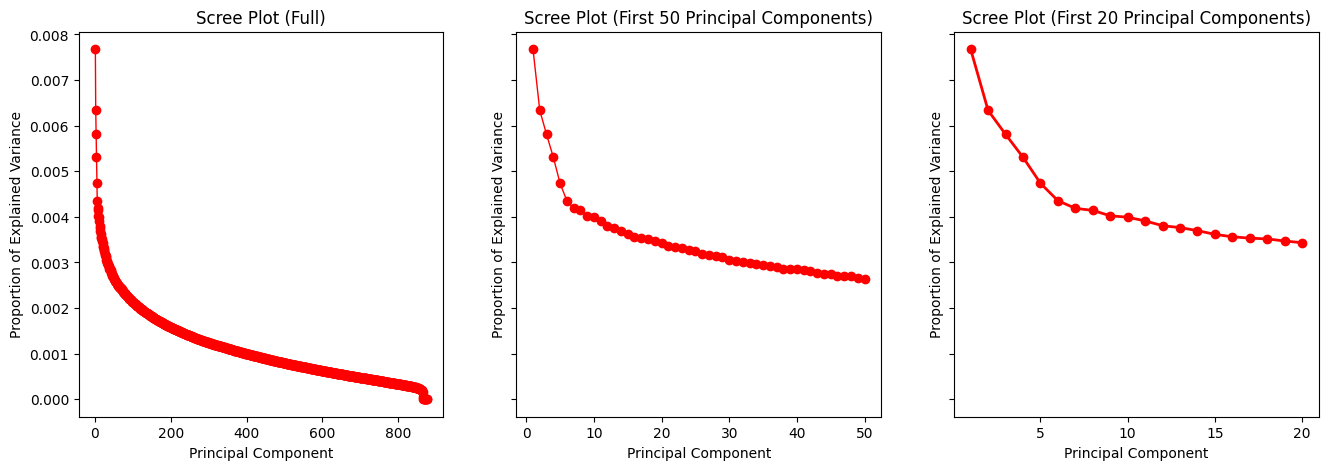

In [73]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 20 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

In [92]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['depression'])
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['depression'])

0.8527397260273972

In [77]:
train_data_df['category'] = train_data_df['depression']

In [80]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['depression'])

0.8272727272727273

- 10 dimensions are enough to achieve 80% accuracy.

In [33]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['depression'])

print("40:")
print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['depression']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['depression']))
print("\n")

train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['depression'])

print("100:")
print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['depression']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['depression']))
print("\n")

train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['depression'])

print("200:")
print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['depression']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['depression']))
print("\n")

train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['depression'])

print("400:")
print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['depression']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['depression']))

40:
Training:
0.867579908675799
Testing:
0.8181818181818182


100:
Training:
0.882420091324201
Testing:
0.8272727272727273


200:
Training:
0.9029680365296804
Testing:
0.8272727272727273


400:
Training:
0.9440639269406392
Testing:
0.8454545454545455


In [53]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['depression'])

print("400:")
print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['depression']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['depression']))

400:
Training:
0.9440639269406392
Testing:
0.8454545454545455


- Performance continues to increase up to 400 components.

In [34]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['depression'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['depression']))
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['depression']))

0.9703196347031964
0.8545454545454545


- L1 penalty result is even better, and should have fewer (non-zero) components as well.

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


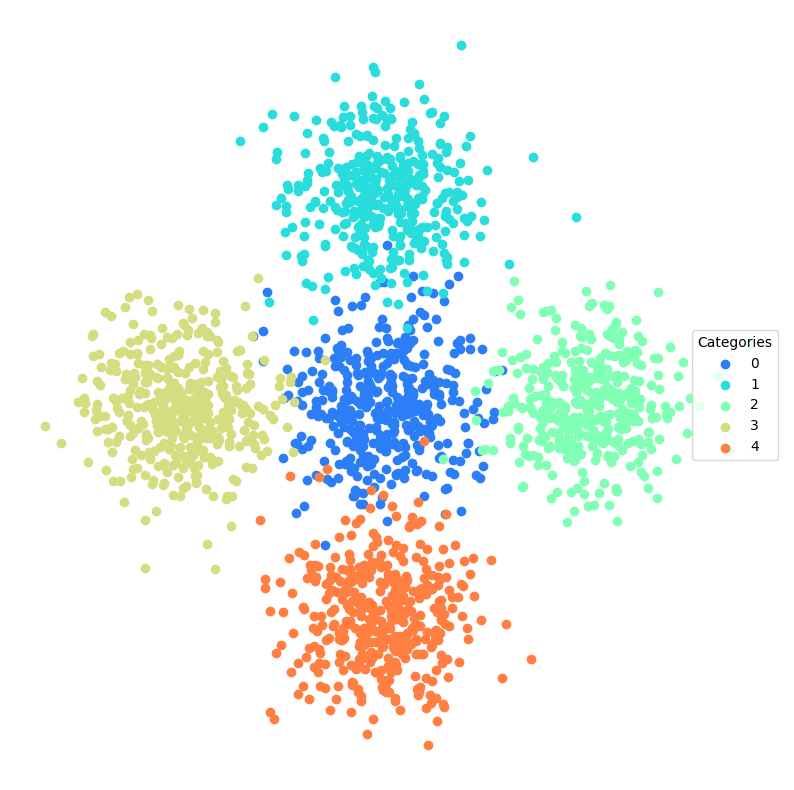

In [120]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = sklearn.model_selection.train_test_split(blobs_df, test_size=.2)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [121]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

To see what's going on visually with the classification:

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


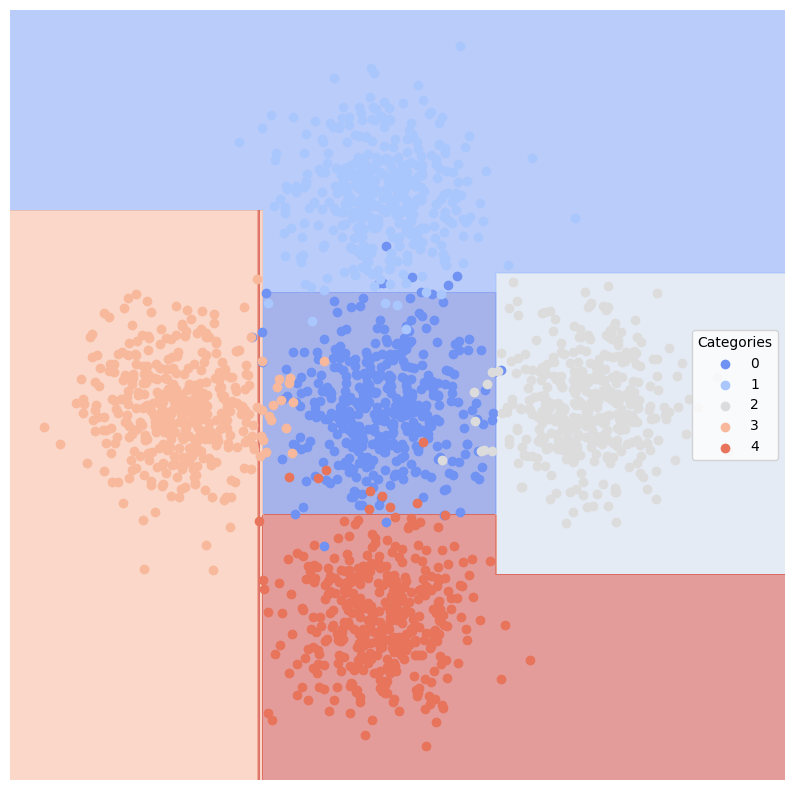

In [122]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [123]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.026,0.975564,0.890000,0.874440,0.978022
1,0.010,0.981161,0.990991,0.964219,0.964912
2,0.006,0.988846,0.990000,0.974396,0.980198
3,0.002,0.994444,1.000000,0.990889,0.988889
4,0.012,0.974699,0.990000,0.952404,0.951923


Lets look at accuracy:

In [124]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.972

What happens if we trim the tree?

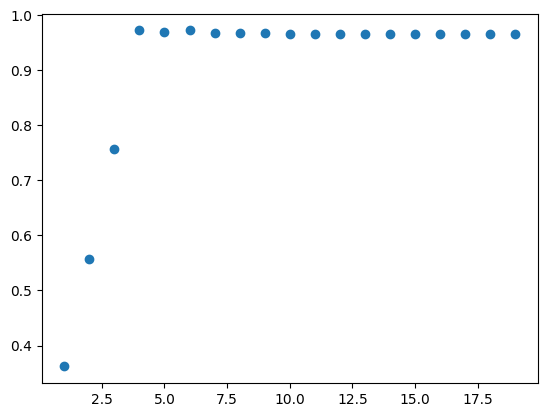

In [125]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [126]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [127]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


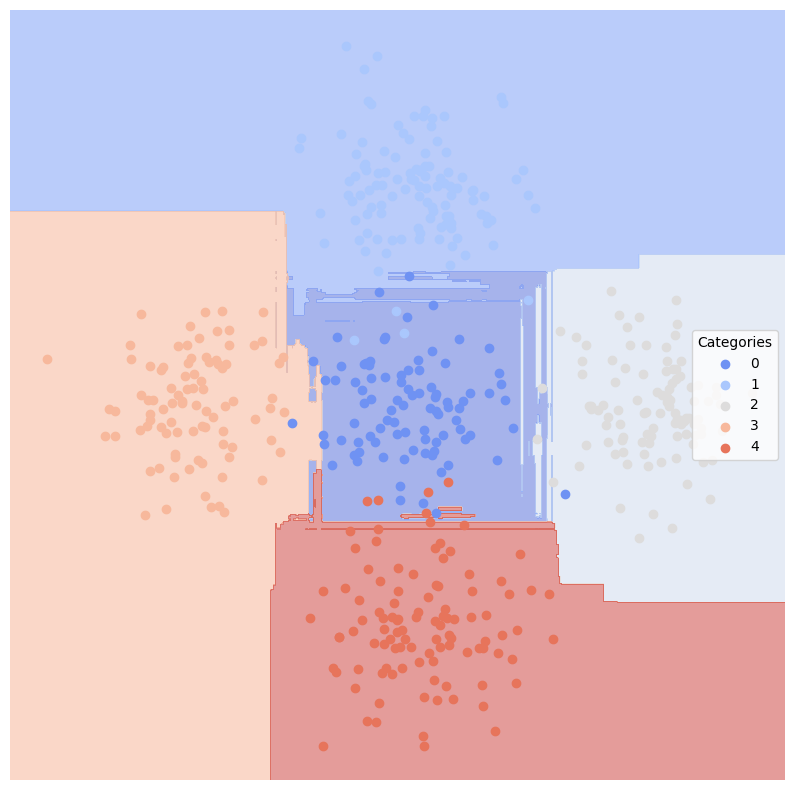

In [128]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [129]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.028,0.970069,0.888889,0.865585,0.967033
1,0.012,0.976775,0.990909,0.957448,0.956140
2,0.004,0.993796,0.990099,0.982296,0.990099
3,0.002,0.998780,0.989011,0.989011,1.000000
4,0.010,0.975962,1.000000,0.961923,0.951923


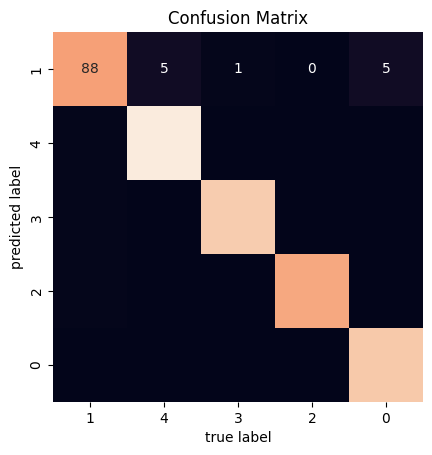

In [130]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

In [132]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


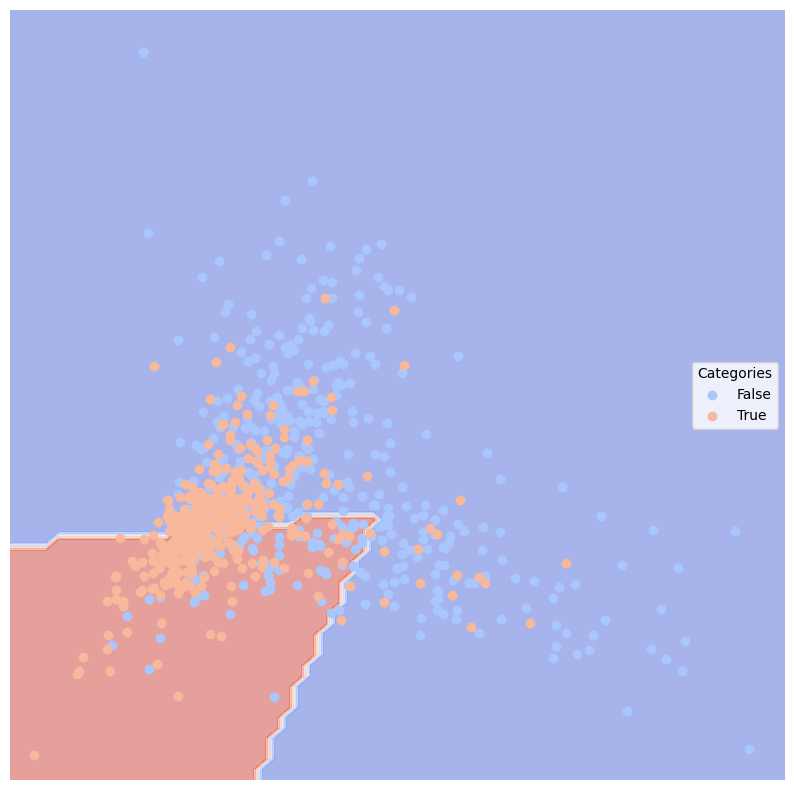

In [133]:
lucem_illud.plotregions(clf_tree, train_data_df)

In [134]:
lucem_illud.evaluateClassifier(clf_tree, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.313636,0.69345,0.907407,0.684387,0.433628
True,0.313636,0.69345,0.614458,0.608472,0.953271


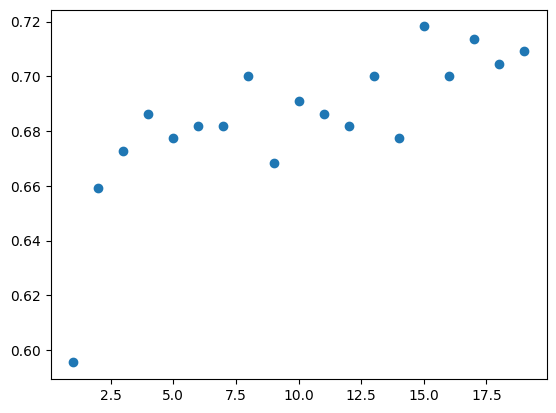

In [136]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])
    score = sklearn.metrics.accuracy_score(test_data_df['category'], tree2.predict(np.stack(test_data_df['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

- This is interesting. It seems there is some performance increase going on but also some overfitting balancing it out.

In [137]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.
bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data
bag.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category']) #Fit the bagged classifier

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


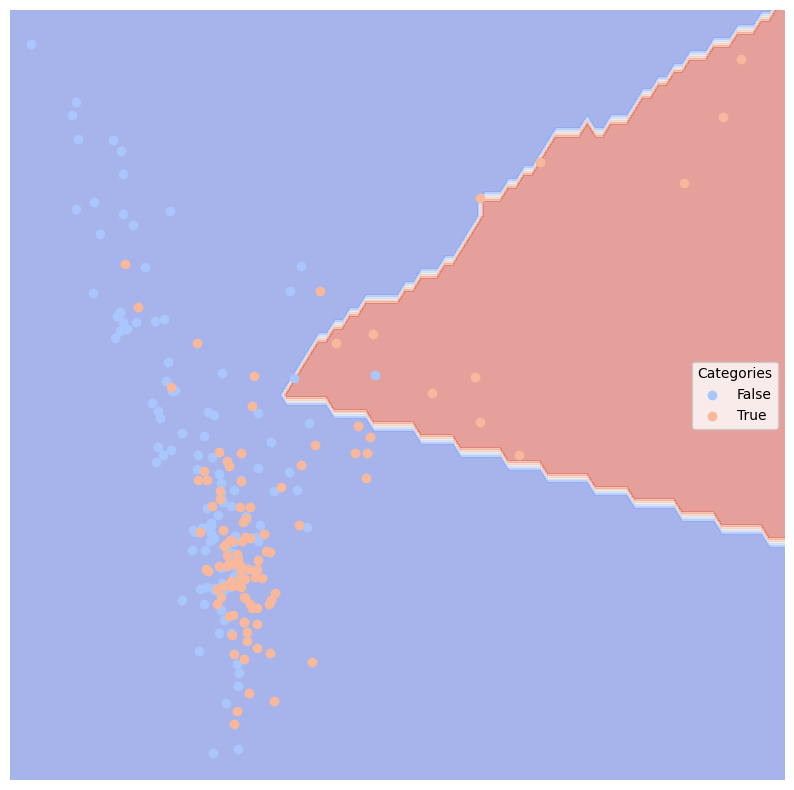

In [138]:
lucem_illud.plotregions(bag, test_data_df)

In [139]:
lucem_illud.evaluateClassifier(bag, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.240909,0.761765,0.833333,0.725825,0.663717
True,0.240909,0.761765,0.707692,0.676665,0.859813


- The random forest improved the performance of the classifier somewhat, but not that much.
- Ensemble learning mixes the result of various component classifiers to create an overall classifier that is less prone to overfitting.

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data.

In [141]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus. # replace path if on Colab
newsgroups.target_names #Possible categories, i.e., the newsgroups

target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


/Users/dan/anaconda3/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [142]:
newsgroupsDF[:5]

,text,category,source_file,tokenized_text,normalized_text
0,\n\nParadise and salvation are not the same th...,talk.religion.misc,../data\20news_home\20news-bydate-train\talk.r...,"[Paradise, and, salvation, are, not, the, same...","[paradise, salvation, thing, salvation, better..."
1,\nYou're admitting a lot more than that. You ...,talk.religion.misc,../data\20news_home\20news-bydate-train\talk.r...,"[You, 're, admitting, a, lot, more, than, that...","[admitting, lot, admitting, morals, situationa..."
2,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,../data\20news_home\20news-bydate-train\talk.r...,"[Jesus, also, recognized, other, holy, days, l...","[jesus, recognized, holy, days, like, passover..."
3,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,talk.religion.misc,../data\20news_home\20news-bydate-train\talk.r...,"[In, <, lsjc8cINNmc1@saltillo.cs.utexas.edu, >...","[<, lsjc8cinnmc1@saltillo.cs.utexas.edu, >, tu..."
4,"\nI'm sorry, but He does not! Ever read the F...",talk.religion.misc,../data\20news_home\20news-bydate-train\talk.r...,"[I, 'm, sorry, but, He, does, not, Ever, read,...","[m, sorry, read, commandment]"


Make a testing and training set:

In [143]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(newsgroupsDF, test_size=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [144]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [145]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [146]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(n_neighbors=15)

In [147]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

/Users/dan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
talk.religion.misc,0.817073,0.502475,0.179592,0.179592,1.000000
comp.graphics,0.270035,0.502141,1.000000,0.274317,0.004283
sci.space,0.274100,0.505241,1.000000,0.284582,0.010482
soc.religion.christian,0.272938,0.500000,0.000000,0.272938,0.000000


And lets look at the testing data

In [148]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.16241299303944315


Let's produce another confusion matrix:

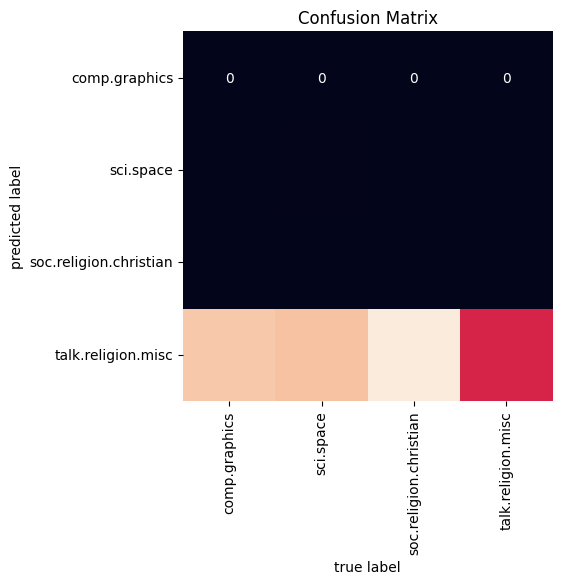

In [149]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


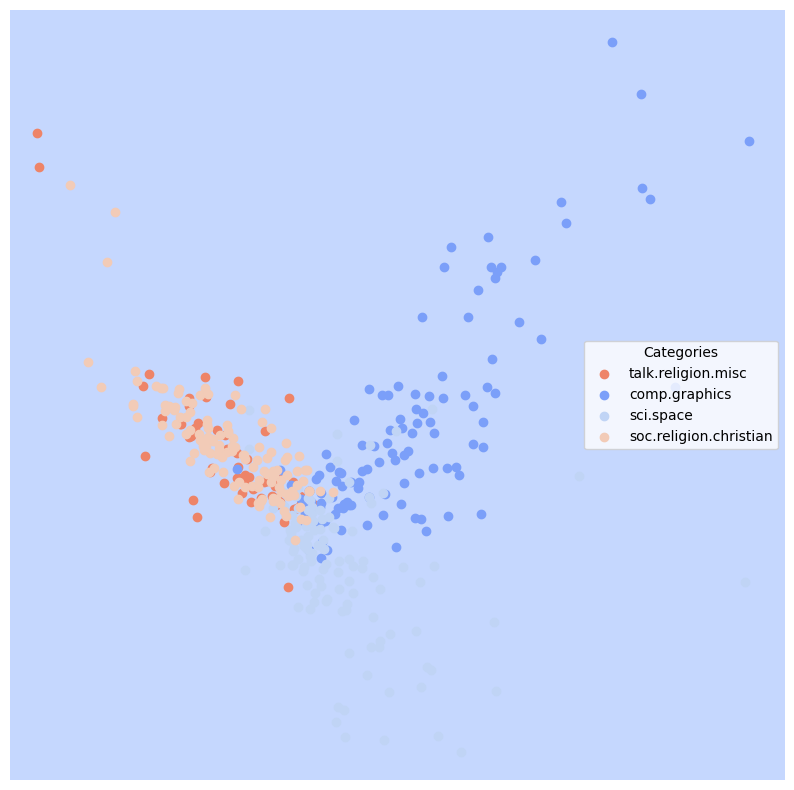

In [150]:
lucem_illud.plotregions(clf_knearest, test_ng_df)

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [151]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [152]:
clf_knearest.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['category'])

KNeighborsClassifier(n_neighbors=15)

In [153]:
lucem_illud.evaluateClassifier(clf_knearest, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.222727,0.772517,0.713333,0.702730,0.946903
True,0.222727,0.772517,0.914286,0.742317,0.598131


In [155]:
print("Testing score:")
print(clf_knearest.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Testing score:
0.7772727272727272


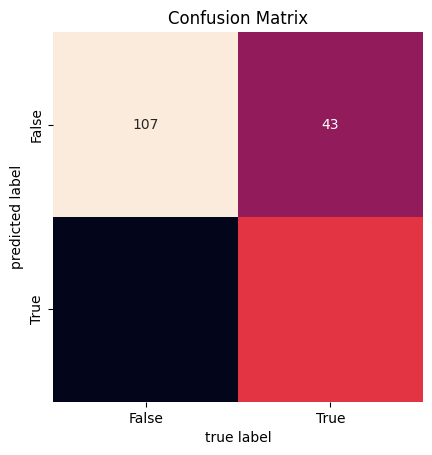

In [156]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_data_df)

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


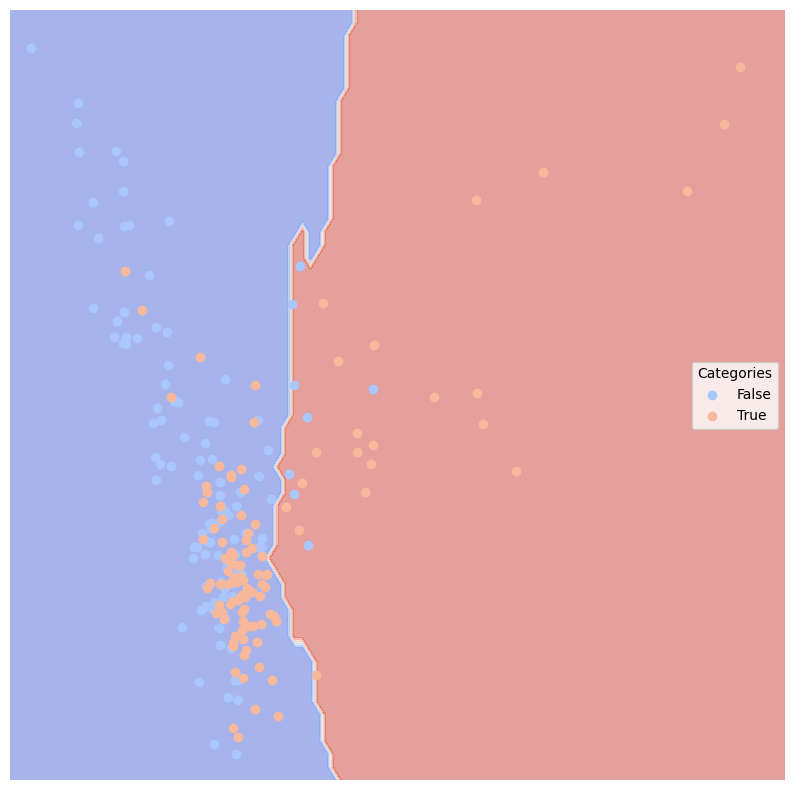

In [157]:
lucem_illud.plotregions(clf_knearest, test_data_df)

- The KNN classifier performed fairly well, better than the decision tree classifier.
- It is similar to k-means clustering in that the values of nearby points are used to create groupings. However, I believe this is a different "k": here it indicates how many neighbors have an influence, whereas with k-means clustering it indicates the desired number of groups.

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [158]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0) # replace path if on Colab

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/Users/dan/anaconda3/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


We will tf.idf the data to make our vectors:

In [159]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [160]:
holdBackFraction = .2
train_redditDf, test_redditDf = sklearn.model_selection.train_test_split(redditDf, test_size=holdBackFraction)

In [161]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(kernel='linear')

...and consider the results:

In [162]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Weeaboo Tales: stories about the extreme fans of japanese culture,0.003125,0.993671,1.000000,0.990467,0.987342
Bad Roommates: Tales of Irritation,0.006250,0.991667,0.987500,0.978281,0.987500
Tales From Tech Support,0.000000,1.000000,1.000000,1.000000,1.000000
Relationships,0.003125,0.997899,0.987952,0.987952,1.000000


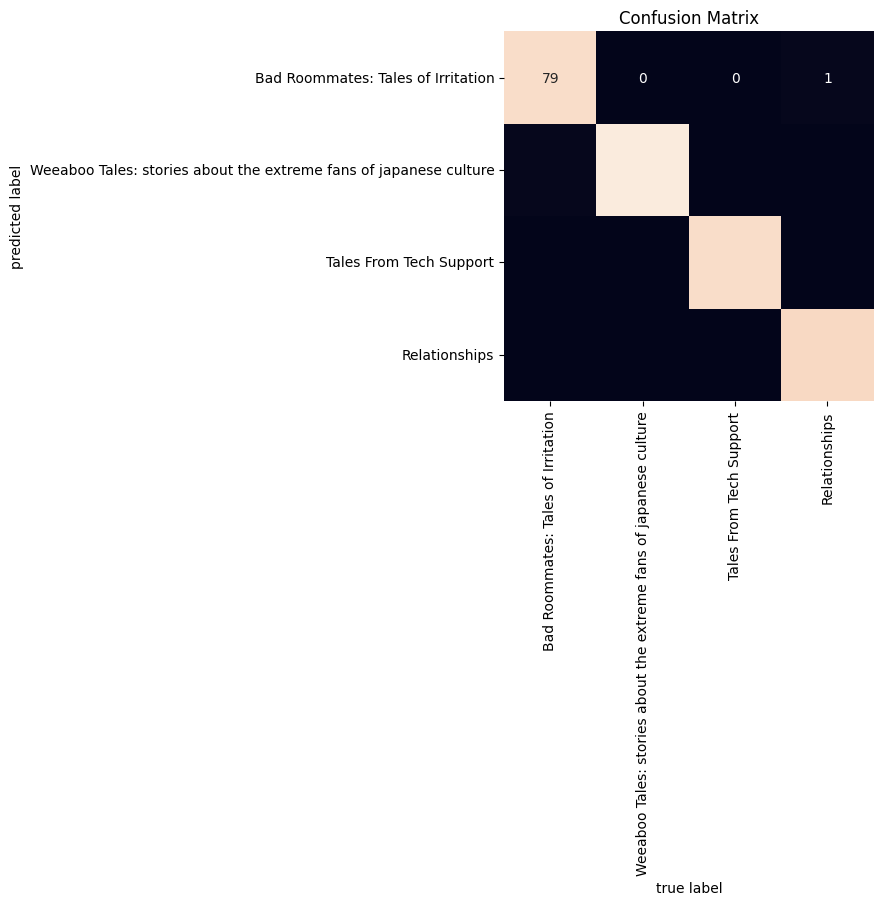

In [163]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


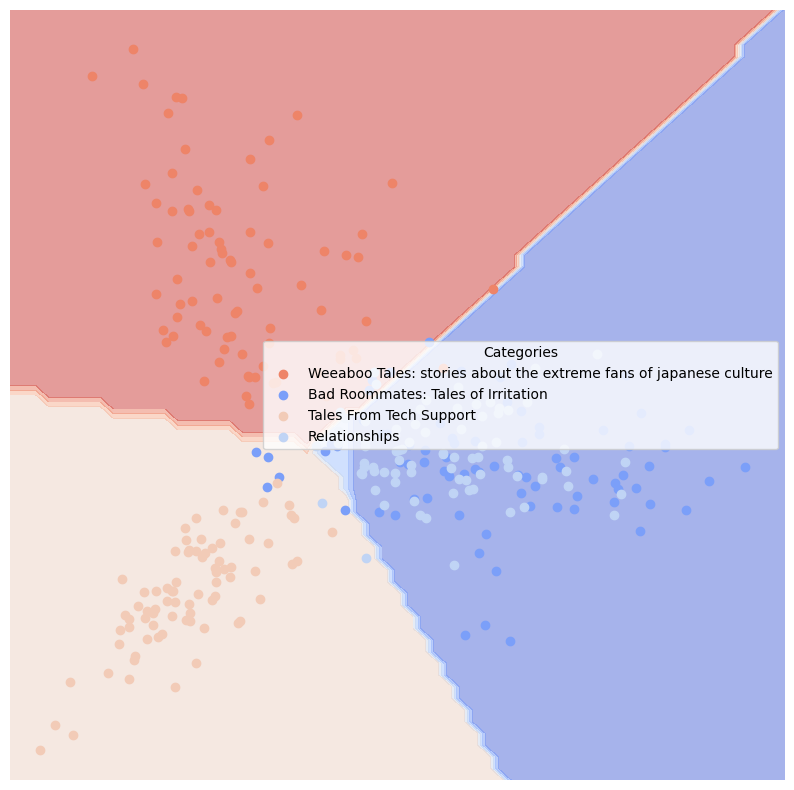

In [164]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $z = w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $f(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/MLP.jpg?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/MLP.jpg?raw=true" style="width:500px">

In [165]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier()

In [166]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Weeaboo Tales: stories about the extreme fans of japanese culture,0.006250,0.991596,0.987342,0.977969,0.987342
Bad Roommates: Tales of Irritation,0.015625,0.977083,0.974684,0.947508,0.962500
Tales From Tech Support,0.000000,1.000000,1.000000,1.000000,1.000000
Relationships,0.009375,0.989701,0.975904,0.967127,0.987805


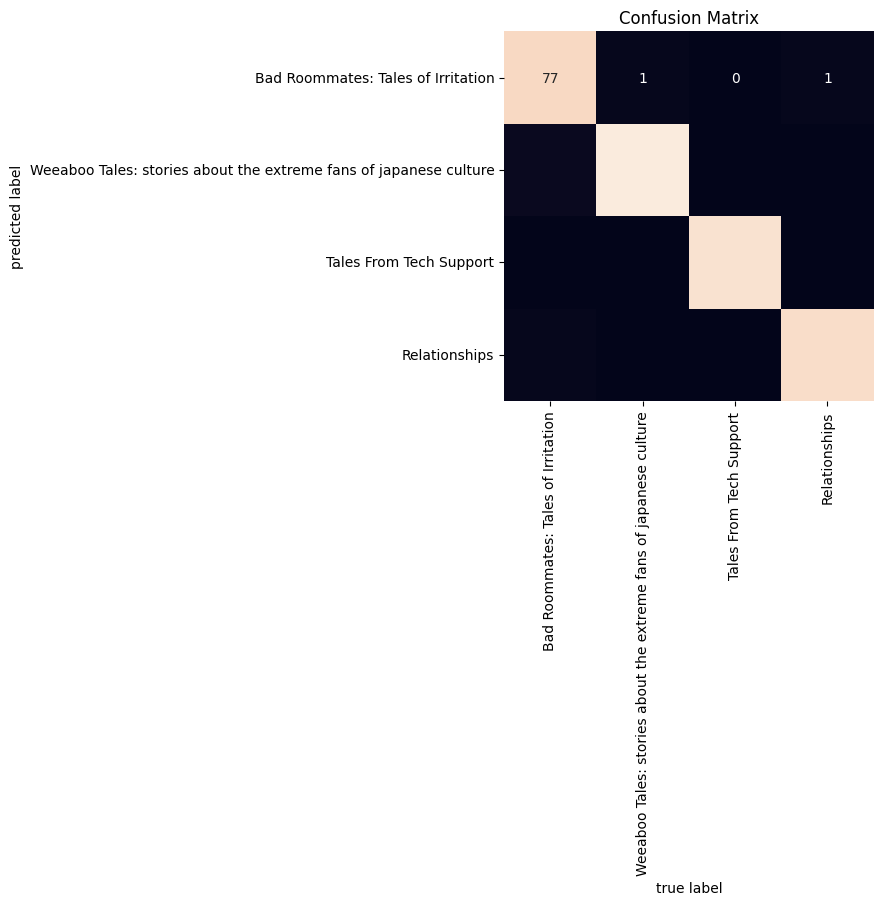

In [167]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


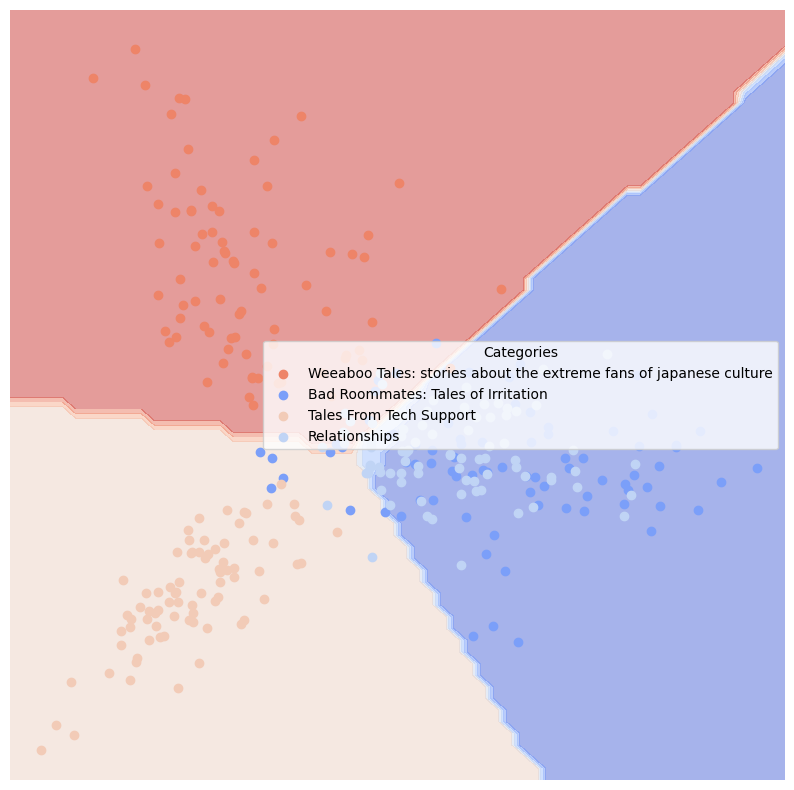

In [168]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, logistic and decision-tree approaches?

In [169]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
clf_svm.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

SVC(kernel='linear')

In [170]:
lucem_illud.evaluateClassifier(clf_svm, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.145455,0.855182,0.878505,0.817155,0.831858
True,0.145455,0.855182,0.831858,0.789882,0.878505


/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


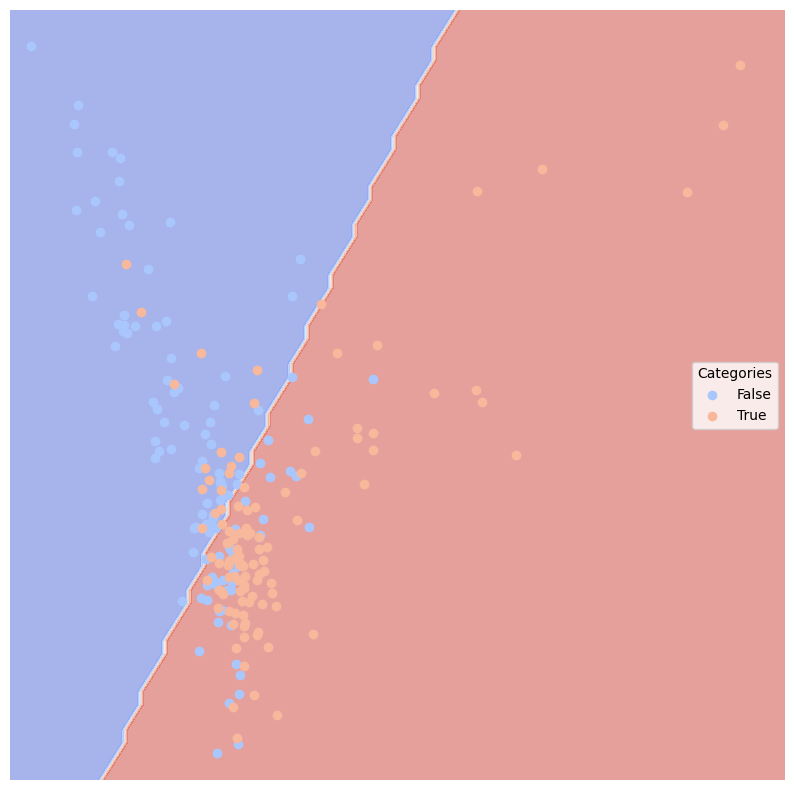

In [171]:
lucem_illud.plotregions(clf_svm, test_data_df)

In [172]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

MLPClassifier()

In [173]:
lucem_illud.evaluateClassifier(clf_nn, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.15,0.850261,0.863636,0.807884,0.840708
True,0.15,0.850261,0.836364,0.787298,0.859813


/Users/dan/anaconda3/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


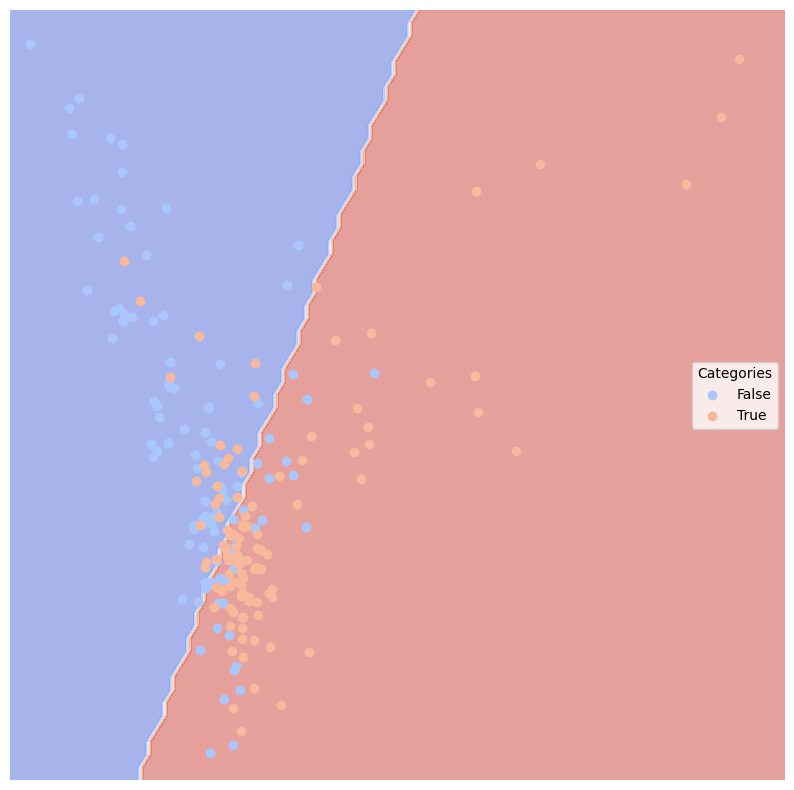

In [174]:
lucem_illud.plotregions(clf_nn, test_data_df)

- The SVM and neural network classifiers perform quite well - better than KNN and decision tree, although not as good as logistic.

## Classification with BERT Pipelines
Now, instead of classifying based on "old" NLP methods, we will now use the popular Transformers package default 'pipelines'. This package has methods for a wide range of common NLP tasks using contextual word embeddings. Note that for this homework, we are not building new contextual models ourselves, merely using existing models in Transformers. We will spend Weeks 7 and 8 learning more about Transformers, so do not worry about fully understanding them this week.

[Transformers Documentation](https://huggingface.co/transformers/)

[Transformers GitHub](https://github.com/huggingface/transformers)

The following sections of code are taken from the [Summary of Tasks](https://huggingface.co/transformers/task_summary.html) page in the Transformers documentation.

### Sequence Classification (e.g., sentiment)
Sequence classification is the task of classifying sequences according to a given number of classes. An example of
sequence classification is the GLUE dataset. If you would like to fine-tune a
model on a GLUE sequence classification task, you may leverage the [pytorch version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/pytorch/text-classification/run_glue.py) and
[pytorch-lightning version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/legacy/pytorch-lightning/run_glue.py)(legacy) or
[tensorflow version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/tensorflow/text-classification/run_glue.py) scripts.

Here is an example of using pipelines to do sentiment analysis: identifying if a sentence is positive or negative. It
leverages a fine-tuned model on sst2, which is a GLUE task.

This returns a label ("POSITIVE" or "NEGATIVE") alongside a score, as follows:

In [12]:
import transformers
print(transformers.__version__)

4.32.1


In [13]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

label: NEGATIVE, with score: 0.9991
label: POSITIVE, with score: 0.9999


Here is an example of doing a sequence classification using a model to determine if two sequences are paraphrases of
each other. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Build a sequence from the two sentences, with the correct model-specific separators token type ids and attention
   masks (`PreTrainedTokenizer.encode` and `PreTrainedTokenizer.__call__` take
   care of this).
3. Pass this sequence through the model so that it is classified in one of the two available classes: 0 (not a
   paraphrase) and 1 (is a paraphrase).
4. Compute the softmax of the result to get probabilities over the classes.
5. Print the results.

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

not paraphrase: 10%
is paraphrase: 90%
not paraphrase: 94%
is paraphrase: 6%


### Extractive Question Answering

Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a
model on a SQuAD task, you may leverage the [run_squad.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/legacy/question-answering/run_squad.py) (legacy) script.


Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It
leverages a fine-tuned model on SQuAD.

In [15]:
from transformers import pipeline
nlp = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/legacy/question-answering/run_squad.py
"""

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the
positions of the extracted answer in the text.

In [16]:
result = nlp(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'the task of extracting an answer from a text given a question', score: 0.6329, start: 34, end: 95
Answer: 'SQuAD dataset', score: 0.5102, start: 147, end: 160


Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define a text and a few questions.
3. Iterate over the questions and build a sequence from the text and the current question, with the correct
   model-specific separators token type ids and attention masks.
4. Pass this sequence through the model. This outputs a range of scores across the entire sequence of tokens (question and
   text), for both the start and end positions.
5. Compute the softmax of the result to get probabilities over the tokens.
6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.
7. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

## <font color="red">*Exercise 7*</font>

<font color="red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

In [28]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [48]:
mTurkPosts = pandas.read_csv('mTurkPosts.csv')


In [49]:
mTurkPosts

,text
0,I started hurting myself tonight... I've never...
1,Estranged mum possibly dying Hi so I'm basical...
2,I got my first birthday present ever today fro...
3,Has anyone tried Trintellix/Brintellix? How lo...
4,All of my friends annoy me I try to hang out w...
5,I don't know what to do with my life and I'm r...
6,Got the news I was 100% cancer free (again) la...
7,is my best friend only using me for her proble...
8,"Is my sister (31) a toxic person, am I (28m) o..."
9,Cheap gifts on the Receiver's side My friend a...


In [51]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [54]:
mTurkPosts['tokenized_text'] = mTurkPosts['text'].apply(lambda x: tokenizer.tokenize(x))

In [59]:
mTurkPosts['tokenized_text'] = mTurkPosts['tokenized_text'].apply(lambda x: x[:500])

In [60]:
for post in mTurkPosts['tokenized_text']:
    print(len(post), post)
    result = nlp(post)[0]
    print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

73 ['I', 'started', 'hurting', 'myself', 'tonight', '.', '.', '.', 'I', "'", 've', 'never', 'done', 'it', 'before', ',', 'but', 'I', 'just', 'can', "'", 't', 'deal', 'with', 'the', 'mental', 'pain', 'anymore', '.', 'I', "'", 'm', 'trying', 'to', 'distract', 'myself', 'with', 'physical', 'pain', '.', 'It', "'", 's', 'weird', 'how', 'it', 'makes', 'you', 'think', 'about', 'that', 'rather', 'than', 'how', 'shit', '##ty', 'things', 'are', '.', '.', '.', 'I', 'guess', 'it', "'", 's', 'temporary', 'relief', ',', 'but', 'it', 'helps', '.']


label: POSITIVE, with score: 0.9797
500 ['E', '##stra', '##nged', 'mum', 'possibly', 'dying', 'Hi', 'so', 'I', "'", 'm', 'basically', 'in', 'need', 'of', 'some', 'help', 'here', 'with', 'a', 'big', 'issue', 'from', 'people', 'who', 'have', 'possibly', 'experienced', 'something', 'similar', '.', 'So', 'it', "'", 's', 'a', 'long', 'story', 'and', 'I', "'", 'll', 'try', 'and', 'keep', 'it', 'to', 'the', 'parts', 'the', 'are', 'mine', 'to', 'tell', 'to', 'keep', 'things', 'less', 'complicated', '.', 'So', 'first', 'things', 'first', 'me', 'and', 'my', 'mother', 'have', 'had', 'a', 'somewhat', 'rocky', 'relationship', 'from', 'since', 'I', 'can', 'remember', ',', 'it', 'was', 'more', 'of', 'a', 'roller', '##coa', '##ster', 'and', 'have', 'been', 'est', '##ranged', 'for', 'a', 'year', '.', 'Although', 'the', 'intense', 'emotional', 'disrupt', 'from', 'the', 'relationship', 'has', 'lasted', 'much', 'longer', '.', 'A', 'brief', 'history', 'of', 'this', 'would', 'be', 'as', 'follows', ',', 'sin

- The sentiment classifier considers all the posts to be positive, which is a bit strange. Perhaps this is because it is going word-by-word, which doesn't really work for this data. Applying some tf-idf preprocessing could also help to bring out more relevant words.